<div id="container" style="position:relative;">
<div style="float:left"><h1>Data Preparation and Exploration: Issued Building Permits </h1></div>
<div style="position:relative; float:right">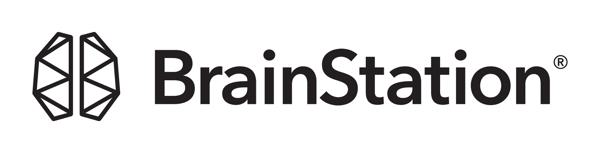
</div>
</div>


**Author:** Tatyana Mozgacheva

Please create the required building_permit environment for this EDA:

conda create -n building_permit python=3.8 numpy pandas matplotlib seaborn jupyter jupyterlab scikit-learn=0.24.1

conda activate building_permit

conda install -c plotly plotly=4.12.0

conda install -c bokeh bokeh=2.2.3

conda install streamlit , scikit-learn , pandas , matplotlib

pip install --upgrade streamlit

pip install --upgrade plotly
pip install nltk

ipython kernel install --name "building_permit" --user

## Table of Contents
[Introduction](#Introduction) 

[1. Loading data & checking high-level details](#1.-Loading-data-&-checking-high-level-details) <br>
- [Data Dictionary](#Data-Dictionary) <br>

[2. Data preparation and cleaning](#Data-preparation-and-cleaning) <br>

[3. Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-(EDA))
- [Univariate Visualizations](#Univariate-Visualizations) <br>
- [Multivariate Visualizations](#Multivariate-Visualizations) <br>
- [Time Series](#Time-Series) <br>

[4. EDA Conclusion](#EDA-Conclusion) <br>
[5. Feature Engineering](#Feature-Engineering)<br>
[6. Baseline models](#Baseline-models)<br>
[7. Next steps...](#Next-steps...)<br>

In [225]:
# Data Visualization and Exploration
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import geopandas as gpd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot
from scipy import stats

#Data Processing 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np

# NLP
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import string

#Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

#Model Evaluation and Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import ttest_ind
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#Time Series Analysis
from statsmodels.api import tsa # time series analysis

#Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# Introduction

## Dataset
Throughout this notebook I will use the `issued-building-permits.csv` dataset. 

Building permits are required for new buildings, additions or alterations to existing buildings, and for demolitions or salvage and abatement work.

You can download the dataset from [here](https://opendata.vancouver.ca/explore/dataset/issued-building-permits/export/)

The GitHub project is [here](https://github.com/tmozgach/brainstation_capstone_building_permits) 

## Question of interest

> Does the time it takes to obtain a permit relate to factors like property values, type of work, property use, and location, etc?

## 1. Loading data & checking high-level details

In [118]:
df = pd.read_csv('issued-building-permits.csv', delimiter=";")
df = df[df['IssueYear'] != 2024]
# There may be some loss of quality from data entry errors and omissions, 
# in particular where the original application date was prior to May 2016 (when permit software changed).
df = df[df['IssueYear'] != 2013]
df = df[df['IssueYear'] != 2014]
df = df[df['IssueYear'] != 2015]
df = df[df['IssueYear'] != 2016]
df.head()

,PermitNumber,PermitNumberCreatedDate,IssueDate,PermitElapsedDays,ProjectValue,TypeOfWork,Address,ProjectDescription,PermitCategory,Applicant,ApplicantAddress,PropertyUse,SpecificUseCategory,BuildingContractor,BuildingContractorAddress,IssueYear,GeoLocalArea,Geom,YearMonth,geo_point_2d
0,DB-2023-00041,2023-01-05,2023-04-28,113,198847.5,New Building,"7475 DUMFRIES STREET, Vancouver, BC",Low Density Housing - New Building - To constr...,New Build - Standalone Laneway,Shalindro Dosanjh,"1185 49 th Ave West\r\nVancouver,, BC V6M 2P9",Dwelling Uses,Laneway House,Amcata Homes Developments Ltd,"1185 W 49TH AV \r\nVancouver, BC V6M 2P9",2023,Victoria-Fraserview,"{""coordinates"": [-123.0755831, 49.2165995], ""t...",2023-04,"49.2165995, -123.0755831"
1,BP-2023-00049,2023-01-06,2023-03-29,82,0.0,Salvage and Abatement,"1137 E 29TH AVENUE, Vancouver, BC V5V 2S7",Low Density Housing - Salvage and Abatement - ...,NaN,John Keen DBA: Farpoint Architectural Inc.,"1662 West 75th Ave.\r\nVancouver, BC V6P 6G2",Dwelling Uses,Single Detached House,Vancouver Excavating and Contracting Ltd,"25 Howard Ave \r\nBurnaby, BC V5B 3P3",2023,Kensington-Cedar Cottage,"{""coordinates"": [-123.081827, 49.244843], ""typ...",2023-03,"49.244843, -123.081827"
2,DB-2023-00050,2023-01-06,2023-09-12,249,1068777.5,New Building,"85 W 48TH AVENUE, Vancouver, BC V5Y 2Y5",Low Density Housing - New Building - To constr...,New Build - Low Density Housing,Embark Homes DBA: Embark Homes LTD,"501-4289 Hastings Street\r\nBurnaby, BC V5C0K9",Dwelling Uses,Single Detached House w/Sec Suite,Embark Homes LTD,NaN,2023,Oakridge,"{""coordinates"": [-123.1079161, 49.2270346], ""t...",2023-09,"49.2270346, -123.1079161"
3,DB-2023-00064,2023-01-06,2023-10-04,271,155030.0,New Building,"95 E 59TH AVENUE #3, Vancouver, BC",Low Density Housing - New Building - To constr...,New Build - Standalone Laneway,Wayne Ng DBA: Skymark Engineering Ltd,"3383 Queens Ave\r\nVancouver, BC V5R 4T9",Dwelling Uses,Laneway House,Semlin Construction Ltd,"949 Esmond Ave \r\nBurnaby, BC V5C 6A6",2023,Sunset,"{""coordinates"": [-123.1041746, 49.2170343], ""t...",2023-10,"49.2170343, -123.1041746"
4,DB-2023-00065,2023-01-06,2023-03-31,84,692250.0,New Building,NaN,Low Density Housing - New Building - To constr...,New Build - Low Density Housing,Jordan Talhan DBA: 0686632 BC LTD,"12945 56A Avenue \r\nSurrey, BC V3X2Z1",Dwelling Uses,Duplex w/Secondary Suite,Rungur Sherhomes Group Ltd,NaN,2023,NaN,NaN,2023-03,NaN


In [119]:
df[df["Applicant"].str.contains("Bosa")]

,PermitNumber,PermitNumberCreatedDate,IssueDate,PermitElapsedDays,ProjectValue,TypeOfWork,Address,ProjectDescription,PermitCategory,Applicant,ApplicantAddress,PropertyUse,SpecificUseCategory,BuildingContractor,BuildingContractorAddress,IssueYear,GeoLocalArea,Geom,YearMonth,geo_point_2d
12153,BP-2022-01648,2022-03-31,2022-10-06,189,98790.0,Addition / Alteration,"266 E 21ST AVENUE #3, Vancouver, BC V5V 1R1",Low Density Housing - Addition / Alteration - ...,NaN,Dan Cupa DBA: Bosa Properties Inc.,"1201-838 West Hastings Street\r\nVancouver, BC...",Dwelling Uses,Dwelling Unit,NaN,NaN,2022,Riley Park,"{""coordinates"": [-123.0995056, 49.2517963], ""t...",2022-10,"49.2517963, -123.0995056"
14569,BP-2022-03905,2022-08-09,2022-08-23,14,1098000.0,Addition / Alteration,"888 W BROADWAY, Vancouver, BC V5Z 1J8",Field Review - Addition / Alteration - Interio...,Renovation - Commercial/ Mixed Use - Lower Com...,Nina Santiago DBA: Bosa Properties Inc.,838 West Hastings Street\r\nSuite 1100\r\nVanc...,Service Uses,Hotel,Axiom Builders Inc,"838 W HASTINGS ST \r\nUnit 1100\r\nVancouver,...",2022,Fairview,"{""coordinates"": [-123.1227206, 49.2630287], ""t...",2022-08,"49.2630287, -123.1227206"
16571,BP-2022-00293,2022-01-20,2022-04-01,71,1505000.0,Demolition / Deconstruction,"1500 W GEORGIA STREET, Vancouver, BC V6G 2Z6",Enquiry Centre - Demolition / Deconstruction -...,NaN,Bosa Properties Inc.,"838 W Hastings St.\r\n#1100\r\nVancouver, BC ...","Parking Uses,Retail Uses","Parking Area,Retail Store",Axiom Builders Inc,"838 W HASTINGS ST \r\nUnit 1100\r\nVancouver,...",2022,West End,"{""coordinates"": [-123.1307382, 49.2902096], ""t...",2022-04,"49.2902096, -123.1307382"
22472,BP-2018-00821,2018-02-16,2018-03-02,14,12000.0,Salvage and Abatement,"320 GRANVILLE STREET, Vancouver, BC V6C 1S9",Enquiry Centre - Salvage and Abatement - Inter...,NaN,Alistair Clark DBA: Bosa Development,"1300-2025 Willingdon Ave\r\nBurnaby, BC V5C 0J3",Parking Uses,Parking Garage,Bosa Development Corp,"1901 Rosser Av \r\nUnit 500\r\nBurnaby, BC V...",2018,Downtown,"{""coordinates"": [-123.1128415, 49.2855713], ""t...",2018-03,"49.2855713, -123.1128415"
22662,BP-2018-01506,2018-03-20,2018-05-09,50,1600000.0,Demolition / Deconstruction,"320 GRANVILLE STREET, Vancouver, BC V6C 1S9",Enquiry Centre - Demolition / Deconstruction -...,NaN,Alistair Clark DBA: Bosa Development,"1300-2025 Willingdon Ave\r\nBurnaby, BC V5C 0J3",Parking Uses,Parking Garage,Bosa Development Corp,"1901 Rosser Av \r\nUnit 500\r\nBurnaby, BC V...",2018,Downtown,"{""coordinates"": [-123.1128415, 49.2855713], ""t...",2018-05,"49.2855713, -123.1128415"
28324,BP-2022-00294,2022-01-20,2022-03-24,63,0.0,Salvage and Abatement,"1500 W GEORGIA STREET, Vancouver, BC V6G 2Z6",Enquiry Centre - Salvage and Abatement - Inter...,NaN,Bosa Properties Inc.,"838 W Hastings St.\r\n#1100\r\nVancouver, BC ...","Parking Uses,Retail Uses","Parking Area,Retail Store",NaN,NaN,2022,West End,"{""coordinates"": [-123.1307382, 49.2902096], ""t...",2022-03,"49.2902096, -123.1307382"


### Data Dictionary

| Field Name | Type | Description | Sample |
|------------|------|-------------|--------|
| PermitNumber | text | Unique permit number generated at application date; there may be multiple permits for one project site BU - Original Permit application was made in previous software BP - Building Permit DB - Combined Development & Building Permit | BP-2019-04164 |
| PermitNumberCreatedDate | date | The date at which a permit application, created by staff or an online process, receives a permit number | 2019-09-17 |
| IssueDate | date | Date when the specified permit was first issued | 2019-11-15 |
| PermitElapsedDays | integer | Measures the number of days from the creation and assignment of a permit number until the issuance of a permit.  Application processing represents a collaboration between the applicant/customer team and the City.  Timelines may be influenced by a number of factors, some of which include: the volume of instream applications to be processed, completeness of the application, site and project specific requirements impacting application requirements (number of reviews, conditions, design decisions, etc.), staff and customer response times. | 59 |
| ProjectValue | decimal | Estimated construction value at time of original permit issuance; base permit fees are calculated on this value. For commercial and mixed-use projects with multiple buildings on one site, the project value may be entered only on the site permit (and not the permits for each individual building where a $0 value will be shown) | 0 |
| TypeOfWork | text | Categories Include: Addition / Alteration, Demolition / Deconstruction, New Buildings, Outdoor Uses (No Buildings Proposed), Salvage and Abatement, Temporary Buildings / Structures | Salvage and Abatement |
| Address | text | Specific Property Address | 4094 W 30TH AVENUE, Vancouver, BC V6S 1X5 |
| ProjectDescription | text | Scope of work (note: data file prior to 2018 does not include this field) | Low Density Housing - Salvage and Abatement - SALVAGE AND ABATEMENT PERMIT Salvage and Abatement Permit only for Building permit: DB-2019-04161 and to be completed under the supervision of a registered professional.  This permit does not authorize demolition, deconstruction or construction work. QP:  MCA Environmental Consulting Inc. (Tarlochan (Terry) Sunar) Demolition permit: DB-2019-04162 |
| PermitCategory | text | A high level grouping providing a focus on higher volume, lower complexity project scopes. The categorization is derived from data in the TypeofWork, PropertyUse and ProjectDescription fields. This field was added in December 2021 and will be modified to take into account feedback from dataset users | - |
| Applicant | text | Applicant may be property owner or official agent for owner and is often the design professional or their firm | Scott Posno DBA: Scott Posno Design |
| ApplicantAddress | text | Contact information as provided on Permit Application | 1595 W 3rd Avenue Vancouver, BC  V6J 1J8 |
| PropertyUse | text | General use of property; where there is more than one, they are separated by a comma | Dwelling Uses |
| SpecificUseCategory | text | Category of property use; where there is more than one, they are separated by a comma | Single Detached House |
| BuildingContractor | text | Contractor information, if known, at time of permit issuance | Mercia Construction Ltd |
| BuildingContractorAddress | text | Contractor information, as provided by the applicant | - |
| IssueYear | text | Year which permit was first issued | 2019 |
| GeoLocalArea | text | The local area where the building with the Issued Building Permit is found, derived from the building's coordinates or address. The City of Vancouver has 22 local areas (also known as local planning areas). For more details, please see the Local Area Boundary data set. | Dunbar-Southlands |
| Geom | geo shape | These are mapping coordinates for the building corresponding to a Building Permit. Data from the Address attribute are processed by the BC Address Geocoder API. An unmatched address returns null coordinates and will not display on the Map. The permit will still be listed in the Table view. | {"coordinates":[-123.1965627,49.2450036],"type":"Point"} |
| YearMonth | text | No description available for this field. | 2019-11 |
| geo_point_2d | geo point | No description available for this field. | [49.2450036,-123.1965627] |



In [120]:
df.tail()

,PermitNumber,PermitNumberCreatedDate,IssueDate,PermitElapsedDays,ProjectValue,TypeOfWork,Address,ProjectDescription,PermitCategory,Applicant,ApplicantAddress,PropertyUse,SpecificUseCategory,BuildingContractor,BuildingContractorAddress,IssueYear,GeoLocalArea,Geom,YearMonth,geo_point_2d
39552,BP-2023-02460,2023-07-12,2023-11-09,120,2200000.0,Addition / Alteration,"1090 W PENDER STREET, Vancouver, BC V6E 2N7",Certified Professional Program - Addition / Al...,NaN,"Robert Heikkila DBA: CFT Engineering Inc., a J...","#500 - 1901 Rosser Avenue\r\nBurnaby, BC V5C 6R6",Office Uses,General Office,NaN,NaN,2023,Downtown,"{""coordinates"": [-123.1202195, 49.2871644], ""t...",2023-11,"49.2871644, -123.1202195"
39553,BP-2023-02461,2023-07-12,2023-09-25,75,0.0,Salvage and Abatement,"3781 W 18TH AVENUE, Vancouver, BC V6S 1B3",Low Density Housing - Salvage and Abatement - ...,NaN,TIMOTHY TSE DBA: Cadlab Design Inc.,"225-8877 Odlin Cr.\r\nRichmond, BC V6X 3Z7",Dwelling Uses,Single Detached House,Townhill Development Inc.,NaN,2023,Dunbar-Southlands,"{""coordinates"": [-123.1876529, 49.2567512], ""t...",2023-09,"49.2567512, -123.1876529"
39555,DB-2023-02482,2023-07-13,2023-10-20,99,1200000.0,New Building,"3569 W 30TH AVENUE, Vancouver, BC V6S 1W6",Low Density Housing - New Building - To constr...,New Build - Low Density Housing,Danny Lung & Sharon Chen DBA: Lung Designs Gro...,LUNG DESIGNS GROUP LTD\r\nUNIT 268-2633 VIKING...,Dwelling Uses,"Secondary Suite,Duplex w/Secondary Suite",RBC Holdings Ltd,"4112 HEATHER ST \r\nVancouver, BC V5Z 0B5",2023,Dunbar-Southlands,"{""coordinates"": [-123.1839825, 49.2454866], ""t...",2023-10,"49.2454866, -123.1839825"
39557,DB-2023-02489,2023-07-13,2023-09-27,76,676000.0,New Building,"2616 NAPIER STREET, Vancouver, BC V5K 2W6",Low Density Housing - New Building - To constr...,New Build - Low Density Housing,Kuldip Brar,"1244 grand boulevard east\r\nnorth vancouver, ...",Dwelling Uses,Duplex,Brar Empire Homes Ltd,"1244 Grand Blvd \r\nNorth Vancouver, BC V7L 3X4",2023,Hastings-Sunrise,"{""coordinates"": [-123.0515287, 49.2747355], ""t...",2023-09,"49.2747355, -123.0515287"
39558,BP-2021-01316,2021-04-06,2021-08-16,132,129000.0,Addition / Alteration,"2920 VIRTUAL WAY, Vancouver, BC V5M 0C4",Field Review - Addition / Alteration - #30 \r\...,Renovation - Commercial/ Mixed Use - Lower Com...,Jan Van de fliert DBA: BLUE ROCK Construction ...,"43 auburn meadows crescent SE\r\nCalgary, AB ...",Retail Uses,Retail Store,Blue Rock Construction Management Ltd,"43 Auburn Meadows Cres SE \r\nCalgary, AB T3...",2021,Renfrew-Collingwood,"{""coordinates"": [-123.0434214, 49.2610707], ""t...",2021-08,"49.2610707, -123.0434214"


In [121]:
df.sample(15)

,PermitNumber,PermitNumberCreatedDate,IssueDate,PermitElapsedDays,ProjectValue,TypeOfWork,Address,ProjectDescription,PermitCategory,Applicant,ApplicantAddress,PropertyUse,SpecificUseCategory,BuildingContractor,BuildingContractorAddress,IssueYear,GeoLocalArea,Geom,YearMonth,geo_point_2d
12106,DB-2022-01355,2022-03-15,2022-11-04,234,15000.0,Demolition / Deconstruction,"874 E 31ST AVENUE, Vancouver, BC V5V 2X1",Low Density Housing - Demolition / Deconstruct...,NaN,Scott Lin DBA: PTL Design,"300 - 1275 W 6TH AVE\r\nVANCOUVER, BC V6H 1A6",Dwelling Uses,Single Detached House,BESTWAY EXCAVATING & DEMOLITION 2008 LTD,NaN,2022,Kensington-Cedar Cottage,"{""coordinates"": [-123.0864639, 49.242293], ""ty...",2022-11,"49.242293, -123.0864639"
11231,BP-2021-06478,2021-12-09,2022-02-09,62,90000.0,Addition / Alteration,"63 W 6TH AVENUE, Vancouver, BC V5Y 1K2",Field Review - Addition / Alteration - #303 - ...,Renovation - Commercial/ Mixed Use - Lower Com...,Seng Tsoi DBA: STA Office Architecture Inc.,"#200-1675 W 2nd Avenue\r\nVancouver, BC V6J 1H3",Office Uses,General Office,NaN,NaN,2022,Mount Pleasant,"{""coordinates"": [-123.1060707, 49.2656219], ""t...",2022-02,"49.2656219, -123.1060707"
20197,BP-2017-00644,2017-02-03,2018-05-31,482,1300000.0,New Building,"1716 NAPIER STREET, Vancouver, BC V5L 2N2",Certified Professional Program - New Building ...,NaN,"Richard Lau, P.ENG., CP DBA: Camphora Engineering","2479 Kingsway\r\nVancouver, BC V5R 5G8",Dwelling Uses,Multiple Dwelling,Pantheon Developments Ltd,"1625 W 5TH AV \r\nVancouver, BC V6J 1N5",2018,Grandview-Woodland,"{""coordinates"": [-123.0688266, 49.2748309], ""t...",2018-05,"49.2748309, -123.0688266"
10874,BP-2016-03628,2016-11-14,2017-01-18,65,100000.0,Addition / Alteration,"980 HOWE STREET, Vancouver, BC V6Z 1N9",Field Review - Addition / Alteration - (Level ...,Renovation - Commercial/ Mixed Use - Lower Com...,Kirsten Reite DBA: Kirsten Reite Architecture,"939 East Hastings Street\r\nVancouver, BC V6A...",Service Uses,Laboratory,Bon Constructors Inc,"939 E HASTINGS ST \r\nVancouver, BC V6A 0H1",2017,Downtown,"{""coordinates"": [-123.1233318, 49.2799787], ""t...",2017-01,"49.2799787, -123.1233318"
25207,BP-2019-00525,2019-02-06,2019-03-06,28,80000.0,Addition / Alteration,"837 W HASTINGS STREET #PH1, Vancouver, BC V6C 3N7",Field Review - Addition / Alteration - Interio...,Renovation - Residential - Lower Complexity,Vesna Molby DBA: Vesna Molby & Co,"872 Sinclair Street\r\nWest Vancouver, BC V7V...",Dwelling Uses,Multiple Dwelling,NaN,NaN,2019,NaN,NaN,2019-03,NaN
20255,DB-2017-01464,2017-03-21,2017-06-28,99,15000.0,Addition / Alteration,"2623 W 4TH AVENUE, Vancouver, BC V6K 1P8",High Density Housing / Commercial - Addition /...,NaN,Bradbury Architecture DBA: Bradbury Architecture,"440 W Hastings\r\n#350\r\nVancouver, BC V6B1L1",Dwelling Uses,Multiple Conversion Dwelling,NaN,NaN,2017,Kitsilano,"{""coordinates"": [-123.1650635, 49.2685809], ""t...",2017-06,"49.2685809, -123.1650635"
22967,DB-2018-03873,2018-07-17,2018-10-19,94,218500.0,New Building,"2752 W 22ND AVENUE, Vancouver, BC V6L 1M4",Low Density Housing - New Building - To constr...,New Build - Low Density Housing,Sukhbir Dhaliwal / Mountainview Enterprises L...,"2748 West 22nd Avenue \r\nVancouver, BC V6L1M4",Dwelling Uses,Laneway House,Mountainview Enterprises Ltd,"6527 BUTLER ST \r\nVancouver, BC V5S 3K8",2018,Arbutus Ridge,"{""coordinates"": [-123.1665481, 49.2527476], ""t...",2018-10,"49.2527476, -123.1665481"
37241,BP-2023-01336,2023-04-19,2023-05-24,35,0.0,Salvage and Abatement,"2091 E 20TH AVENUE, Vancouver, BC V5N 2L1",Low Density Housing - Salvage and Abatement - ...,NaN,Luis Rivas T. DBA: Luis Construction Designs ...,"15764 92 Avenue\r\nSurrey, BC V4N 2X1",Dwelling Uses,Single Detached House,Fleck Contracting Ltd,"9013 SHAUGHNESSY ST \r\nVancouver, BC V6P 6R9",2023,Kensington-Cedar Cottage,"{""coordinates"": [-123.0630973, 49.2526309], ""t...",2023-05,"49.2526309, -123.0630973"
38750,BP-2023-02507,2023-07-14,2023-08-15

In [122]:
df.shape

(39082, 20)

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39082 entries, 0 to 39558
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PermitNumber               39082 non-null  object 
 1   PermitNumberCreatedDate    39082 non-null  object 
 2   IssueDate                  39082 non-null  object 
 3   PermitElapsedDays          39082 non-null  int64  
 4   ProjectValue               39082 non-null  float64
 5   TypeOfWork                 39082 non-null  object 
 6   Address                    38925 non-null  object 
 7   ProjectDescription         39082 non-null  object 
 8   PermitCategory             22274 non-null  object 
 9   Applicant                  39082 non-null  object 
 10  ApplicantAddress           38978 non-null  object 
 11  PropertyUse                39077 non-null  object 
 12  SpecificUseCategory        39075 non-null  object 
 13  BuildingContractor         24305 non-null  object 


# Data preparation and cleaning

## Step 1: Formatting & Validity


Change the below columns to the Datetime type:

In [124]:
df['PermitNumberCreatedDate'].head(5)

0    2023-01-05
1    2023-01-06
2    2023-01-06
3    2023-01-06
4    2023-01-06
Name: PermitNumberCreatedDate, dtype: object

In [125]:
df['PermitNumberCreatedDate'] = pd.to_datetime(df['PermitNumberCreatedDate'])
df['IssueDate'] = pd.to_datetime(df['IssueDate'])


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39082 entries, 0 to 39558
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   PermitNumber               39082 non-null  object        
 1   PermitNumberCreatedDate    39082 non-null  datetime64[ns]
 2   IssueDate                  39082 non-null  datetime64[ns]
 3   PermitElapsedDays          39082 non-null  int64         
 4   ProjectValue               39082 non-null  float64       
 5   TypeOfWork                 39082 non-null  object        
 6   Address                    38925 non-null  object        
 7   ProjectDescription         39082 non-null  object        
 8   PermitCategory             22274 non-null  object        
 9   Applicant                  39082 non-null  object        
 10  ApplicantAddress           38978 non-null  object        
 11  PropertyUse                39077 non-null  object        
 12  SpecificU

In [127]:
df.head()

,PermitNumber,PermitNumberCreatedDate,IssueDate,PermitElapsedDays,ProjectValue,TypeOfWork,Address,ProjectDescription,PermitCategory,Applicant,ApplicantAddress,PropertyUse,SpecificUseCategory,BuildingContractor,BuildingContractorAddress,IssueYear,GeoLocalArea,Geom,YearMonth,geo_point_2d
0,DB-2023-00041,2023-01-05,2023-04-28,113,198847.5,New Building,"7475 DUMFRIES STREET, Vancouver, BC",Low Density Housing - New Building - To constr...,New Build - Standalone Laneway,Shalindro Dosanjh,"1185 49 th Ave West\r\nVancouver,, BC V6M 2P9",Dwelling Uses,Laneway House,Amcata Homes Developments Ltd,"1185 W 49TH AV \r\nVancouver, BC V6M 2P9",2023,Victoria-Fraserview,"{""coordinates"": [-123.0755831, 49.2165995], ""t...",2023-04,"49.2165995, -123.0755831"
1,BP-2023-00049,2023-01-06,2023-03-29,82,0.0,Salvage and Abatement,"1137 E 29TH AVENUE, Vancouver, BC V5V 2S7",Low Density Housing - Salvage and Abatement - ...,NaN,John Keen DBA: Farpoint Architectural Inc.,"1662 West 75th Ave.\r\nVancouver, BC V6P 6G2",Dwelling Uses,Single Detached House,Vancouver Excavating and Contracting Ltd,"25 Howard Ave \r\nBurnaby, BC V5B 3P3",2023,Kensington-Cedar Cottage,"{""coordinates"": [-123.081827, 49.244843], ""typ...",2023-03,"49.244843, -123.081827"
2,DB-2023-00050,2023-01-06,2023-09-12,249,1068777.5,New Building,"85 W 48TH AVENUE, Vancouver, BC V5Y 2Y5",Low Density Housing - New Building - To constr...,New Build - Low Density Housing,Embark Homes DBA: Embark Homes LTD,"501-4289 Hastings Street\r\nBurnaby, BC V5C0K9",Dwelling Uses,Single Detached House w/Sec Suite,Embark Homes LTD,NaN,2023,Oakridge,"{""coordinates"": [-123.1079161, 49.2270346], ""t...",2023-09,"49.2270346, -123.1079161"
3,DB-2023-00064,2023-01-06,2023-10-04,271,155030.0,New Building,"95 E 59TH AVENUE #3, Vancouver, BC",Low Density Housing - New Building - To constr...,New Build - Standalone Laneway,Wayne Ng DBA: Skymark Engineering Ltd,"3383 Queens Ave\r\nVancouver, BC V5R 4T9",Dwelling Uses,Laneway House,Semlin Construction Ltd,"949 Esmond Ave \r\nBurnaby, BC V5C 6A6",2023,Sunset,"{""coordinates"": [-123.1041746, 49.2170343], ""t...",2023-10,"49.2170343, -123.1041746"
4,DB-2023-00065,2023-01-06,2023-03-31,84,692250.0,New Building,NaN,Low Density Housing - New Building - To constr...,New Build - Low Density Housing,Jordan Talhan DBA: 0686632 BC LTD,"12945 56A Avenue \r\nSurrey, BC V3X2Z1",Dwelling Uses,Duplex w/Secondary Suite,Rungur Sherhomes Group Ltd,NaN,2023,NaN,NaN,2023-03,NaN


In [128]:
df.describe()

,PermitNumberCreatedDate,IssueDate,PermitElapsedDays,ProjectValue,IssueYear
count,39082,39082,39082.000000,3.908200e+04,39082.000000
mean,2019-11-25 12:41:38.132132608,2020-04-10 03:47:18.032854272,136.628934,7.173252e+05,2019.784453
min,2013-07-25 00:00:00,2017-01-03 00:00:00,0.000000,0.000000e+00,2017.000000
25%,2018-02-09 00:00:00,2018-06-18 00:00:00,40.000000,1.030052e+04,2018.000000
50%,2019-10-02 00:00:00,2020-02-04 00:00:00,90.000000,4.800000e+04,2020.000000
75%,2021-09-13 00:00:00,2022-02-17 00:00:00,193.000000,2.250000e+05,2022.000000
max,2023-12-22 00:00:00,2023-12-22 00:00:00,1716.000000,1.468680e+09,2023.000000
std,NaN,NaN,138.981307,1.092001e+07,2.036364


## Step 2: Checking for duplicates and redundant information 


As we can see below, no duplicates:

In [129]:
df.duplicated().sum()

0

In [130]:
df.T.duplicated()

PermitNumber                 False
PermitNumberCreatedDate      False
IssueDate                    False
PermitElapsedDays            False
ProjectValue                 False
TypeOfWork                   False
Address                      False
ProjectDescription           False
PermitCategory               False
Applicant                    False
ApplicantAddress             False
PropertyUse                  False
SpecificUseCategory          False
BuildingContractor           False
BuildingContractorAddress    False
IssueYear                    False
GeoLocalArea                 False
Geom                         False
YearMonth                    False
geo_point_2d                 False
dtype: bool

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39082 entries, 0 to 39558
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   PermitNumber               39082 non-null  object        
 1   PermitNumberCreatedDate    39082 non-null  datetime64[ns]
 2   IssueDate                  39082 non-null  datetime64[ns]
 3   PermitElapsedDays          39082 non-null  int64         
 4   ProjectValue               39082 non-null  float64       
 5   TypeOfWork                 39082 non-null  object        
 6   Address                    38925 non-null  object        
 7   ProjectDescription         39082 non-null  object        
 8   PermitCategory             22274 non-null  object        
 9   Applicant                  39082 non-null  object        
 10  ApplicantAddress           38978 non-null  object        
 11  PropertyUse                39077 non-null  object        
 12  SpecificU

## Step 3 - Missing Data

First, I look at the number of missing values in each column:

In [132]:
df.isna().sum()

PermitNumber                     0
PermitNumberCreatedDate          0
IssueDate                        0
PermitElapsedDays                0
ProjectValue                     0
TypeOfWork                       0
Address                        157
ProjectDescription               0
PermitCategory               16808
Applicant                        0
ApplicantAddress               104
PropertyUse                      5
SpecificUseCategory              7
BuildingContractor           14777
BuildingContractorAddress    22232
IssueYear                        0
GeoLocalArea                   467
Geom                           459
YearMonth                        0
geo_point_2d                   459
dtype: int64

Let's look at the percentage of missing values instead:

In [133]:
df.isna().mean()*100

PermitNumber                  0.000000
PermitNumberCreatedDate       0.000000
IssueDate                     0.000000
PermitElapsedDays             0.000000
ProjectValue                  0.000000
TypeOfWork                    0.000000
Address                       0.401719
ProjectDescription            0.000000
PermitCategory               43.007011
Applicant                     0.000000
ApplicantAddress              0.266107
PropertyUse                   0.012794
SpecificUseCategory           0.017911
BuildingContractor           37.810245
BuildingContractorAddress    56.885523
IssueYear                     0.000000
GeoLocalArea                  1.194923
Geom                          1.174454
YearMonth                     0.000000
geo_point_2d                  1.174454
dtype: float64

In [134]:
df["PermitCategory"].value_counts()

PermitCategory
Renovation - Commercial/ Mixed Use - Lower Complexity    7848
Renovation - Residential - Lower Complexity              6900
New Build - Low Density Housing                          5891
New Build - Standalone Laneway                           1635
Name: count, dtype: int64

**Insights:**

1) It makes sense that the PermitCategory column might have missing values. Here's why:

Focus on higher volume, lower complexity projects: You mentioned that the PermitCategory field focuses on higher volume project scopes. This implies that not all permits necessarily fall into these categories. Permits for less common or more complex projects might not have been assigned a PermitCategory label.

2) In addition to this, I don't care about BuildingContractor and BuildingContractorAddress

That's why I think I won't use those columns.

3) The missing data which makes up less than 3% of the total observations in a column will not make much of a difference. Thus, I will delete them and only for the columns, that will be used;

In [135]:
columns_to_drop = ['Address', 'PermitCategory', 'ApplicantAddress', 'BuildingContractor','BuildingContractorAddress']
df.drop(columns=columns_to_drop, inplace=True)

rows_to_drop = ['PropertyUse', 'SpecificUseCategory', 'GeoLocalArea','Geom', 'geo_point_2d']
df.dropna(subset=rows_to_drop, inplace=True)

In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38608 entries, 0 to 39558
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   PermitNumber             38608 non-null  object        
 1   PermitNumberCreatedDate  38608 non-null  datetime64[ns]
 2   IssueDate                38608 non-null  datetime64[ns]
 3   PermitElapsedDays        38608 non-null  int64         
 4   ProjectValue             38608 non-null  float64       
 5   TypeOfWork               38608 non-null  object        
 6   ProjectDescription       38608 non-null  object        
 7   Applicant                38608 non-null  object        
 8   PropertyUse              38608 non-null  object        
 9   SpecificUseCategory      38608 non-null  object        
 10  IssueYear                38608 non-null  int64         
 11  GeoLocalArea             38608 non-null  object        
 12  Geom                     38608 non-nu

In [137]:
df['PermitNumber'].value_counts().sum()

38608

# Exploratory Data Analysis (EDA)

## Univariate Visualizations

In [138]:
# Numerical columns
numerical_columns = ['PermitElapsedDays', 'ProjectValue']

# Categorical columns
categorical_columns = ['PropertyUse','SpecificUseCategory', 'TypeOfWork', 'IssueYear', 'GeoLocalArea']

### Distribution of categorical columns

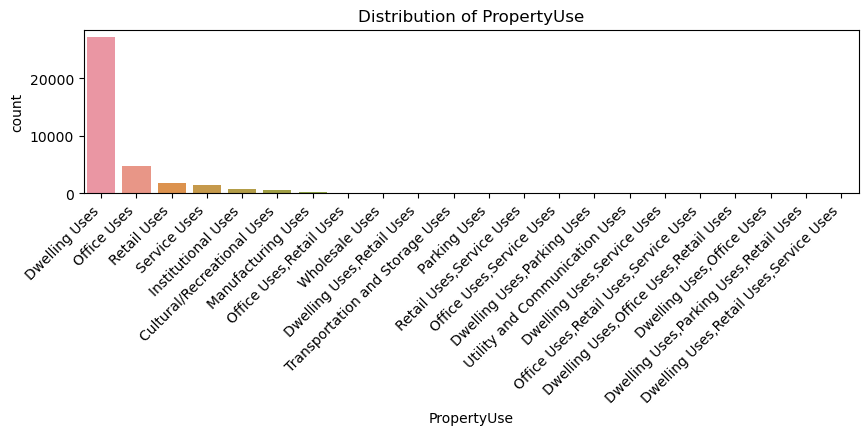

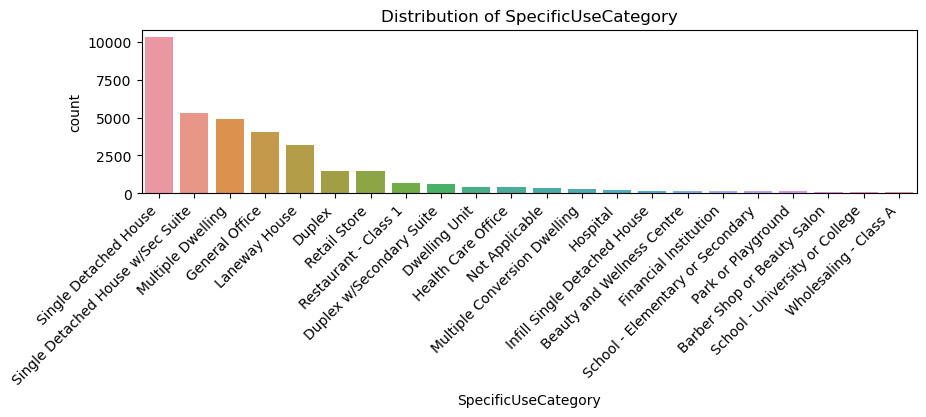

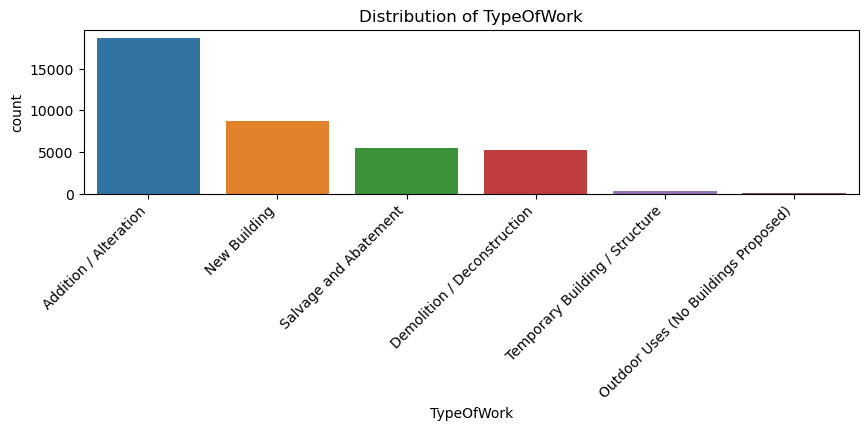

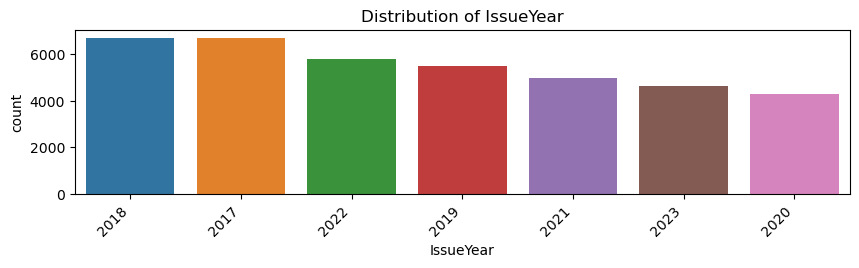

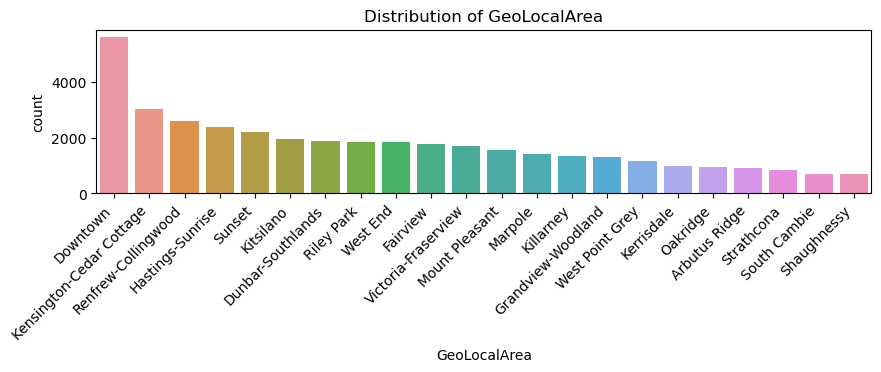

In [139]:
for i, column in enumerate(categorical_columns, 1):
    plt.figure(figsize=(10, 20))
    plt.subplot(8, 1, i)
    sns.countplot(x=column, data=df, order=df[column].value_counts().head(22).index)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45, ha='right')
    plt.show()



In [140]:
for i, column in enumerate(categorical_columns, 1):
    print(df[column].value_counts().head(40))
    print("----------")

PropertyUse
Dwelling Uses                                          27148
Office Uses                                             4800
Retail Uses                                             1874
Service Uses                                            1528
Institutional Uses                                       767
Cultural/Recreational Uses                               598
Manufacturing Uses                                       289
Office Uses,Retail Uses                                  148
Wholesale Uses                                           141
Dwelling Uses,Retail Uses                                125
Transportation and Storage Uses                          119
Parking Uses                                             107
Retail Uses,Service Uses                                  88
Office Uses,Service Uses                                  78
Dwelling Uses,Parking Uses                                71
Utility and Communication Uses                            61
Dwelling Use

### Distribution of numerical columns

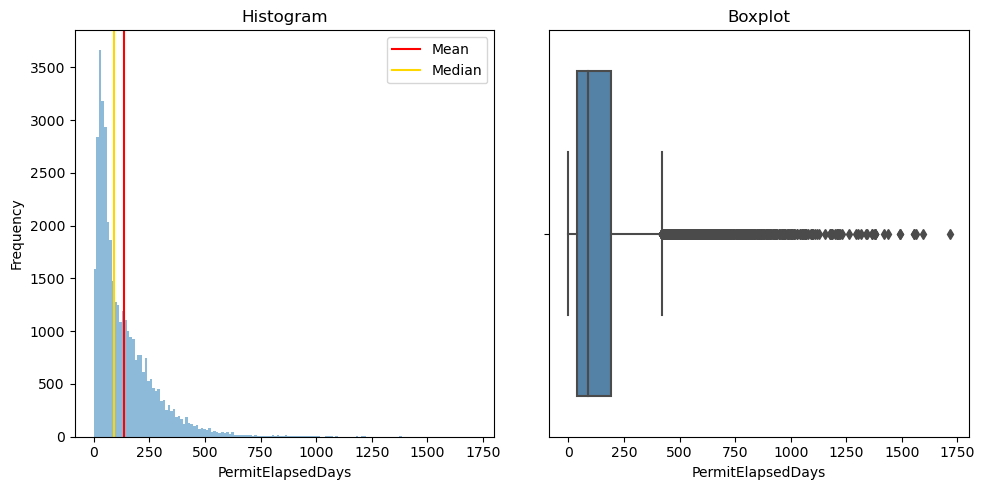

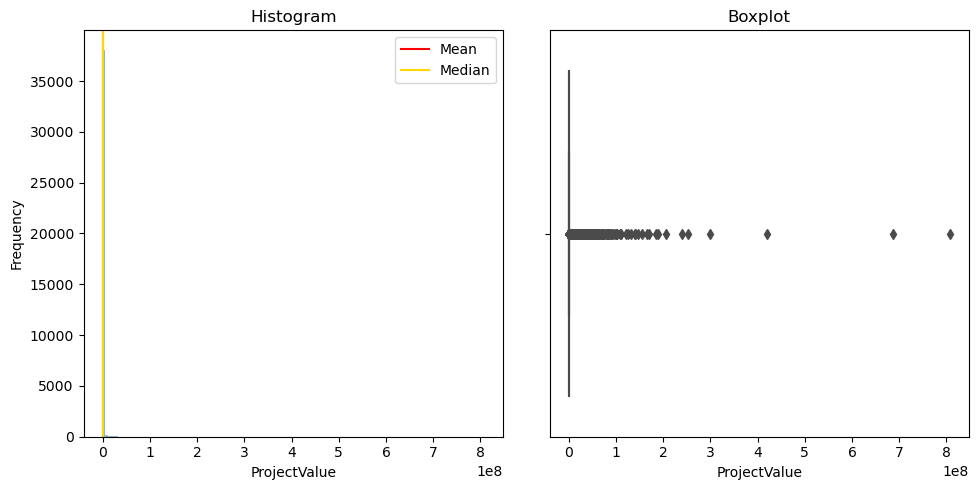

In [141]:
for col in numerical_columns:
    plt.subplots(1, 2, figsize=(10, 5))

    
    # Plot out the histogram
    plt.subplot(1, 2, 1)
    plt.hist(df[col], bins=150, alpha=0.5)
    plt.title('Histogram')
    plt.xlabel(f'{col}')
    plt.ylabel('Frequency')
    plt.axvline(df[col].mean(), c='red', label='Mean')
    plt.axvline(df[col].median(), c='gold', label='Median')
    plt.legend() 
    plt.tight_layout()

    # Plot the boxplot. We can use the seaborn boxplot code for this.
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col], color="steelblue")
    plt.title('Boxplot')


    plt.show()

In [142]:
for i, column in enumerate(numerical_columns, 1):
    print(df[column].describe())
    print("----------")

count    38608.000000
mean       136.249378
std        138.588963
min          0.000000
25%         40.000000
50%         90.000000
75%        192.000000
max       1716.000000
Name: PermitElapsedDays, dtype: float64
----------
count    3.860800e+04
mean     6.577189e+05
std      7.772650e+06
min      0.000000e+00
25%      1.050000e+04
50%      4.696000e+04
75%      2.250000e+05
max      8.071855e+08
Name: ProjectValue, dtype: float64
----------


**Insights:**
1) Predominantly, permits are issued for Dwelling Uses (single detached house, duplex) and Office Uses (General office). The number of permits for Dwelling Uses is approximately five times higher than that for Office Uses.

2) Addition/Alteration is the most common permit type, outnumbering New Building permits by a factor of five.

3) The year 2020 witnessed the lowest number of issued permits, possibly attributed to the impact of COVID-19 lockdown measures.

4) The Downtown area stands out with the highest number of issued permits, indicating increased construction or renovation activity.

5) On average, the waiting time for permit issuance is 136 days. However, the presence of numerous outliers suggests significant variations in processing times.


## Multivariate Visualizations

Let's explore the connection between property value and the waiting time for a permit.

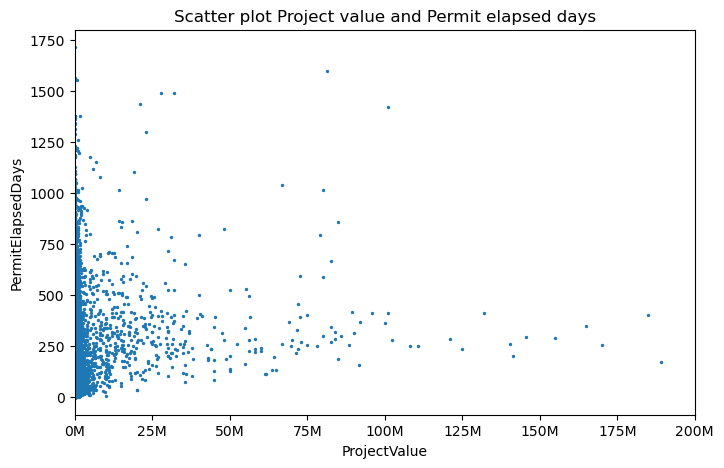

In [143]:
from matplotlib.ticker import FuncFormatter

def millions_formatter(x, pos):
    return f'{x / 1e6:.0f}M'

plt.figure(figsize=(8, 5))

# using the size parameter to help readability
plt.scatter(df['ProjectValue'], df['PermitElapsedDays'], s=2, )
plt.xlabel('ProjectValue')
plt.ylabel('PermitElapsedDays')
plt.title('Scatter plot Project value and Permit elapsed days')
plt.xlim(0, 200000000)
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.show()

What about relationship between the yaer it was issued and the waiting time for a permit.

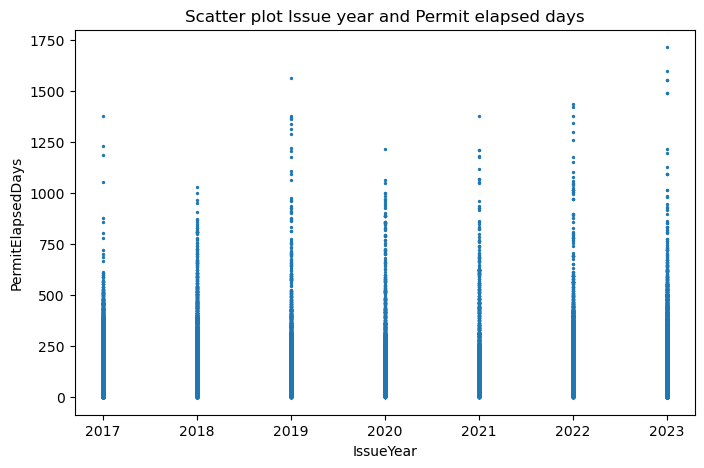

In [144]:
plt.figure(figsize=(8, 5))

# using the size parameter to help readability
plt.scatter(df['IssueYear'], df['PermitElapsedDays'], s=2, )
plt.xlabel('IssueYear')
plt.ylabel('PermitElapsedDays')
plt.title('Scatter plot Issue year and Permit elapsed days')
plt.show()

For now let's take a look into how waiting time(dayes) for a permit varies with type of work.

In [145]:

df.groupby(["TypeOfWork"])["PermitElapsedDays"].describe().sort_values(by='count',ascending=False)

,count,mean,std,min,25%,50%,75%,max
TypeOfWork,,,,,,,,
Addition / Alteration,18756.0,81.363937,109.746263,0.0,28.00,48.0,90.0,1716.0
New Building,8688.0,247.519337,142.771748,0.0,153.00,219.0,307.0,1597.0
Salvage and Abatement,5537.0,79.125158,73.498157,0.0,38.00,62.0,97.0,896.0
Demolition / Deconstruction,5220.0,216.791762,128.031030,0.0,132.00,189.5,271.0,1555.0
Temporary Building / Structure,355.0,24.135211,41.752686,0.0,2.00,7.0,20.5,389.0
Outdoor Uses (No Buildings Proposed),52.0,105.173077,196.791392,0.0,29.75,60.5,90.5,1093.0


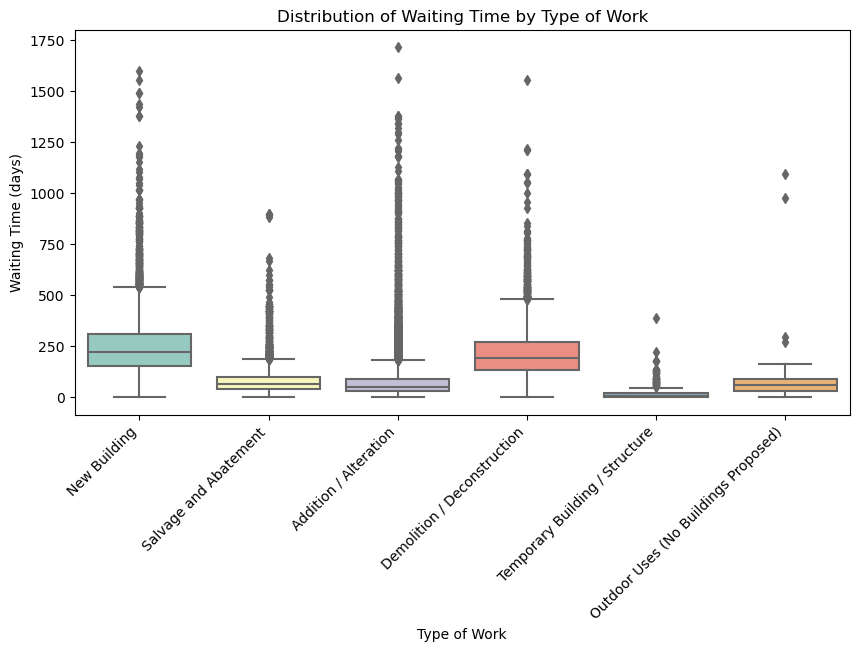

In [146]:
# Create a boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x="TypeOfWork", y="PermitElapsedDays", data=df, palette="Set3")
plt.title("Distribution of Waiting Time by Type of Work")
plt.xlabel("Type of Work")
plt.ylabel("Waiting Time (days)")
plt.xticks(rotation=45, ha="right")
plt.show()

In [147]:
from scipy.stats import ttest_ind

# Choose two property use categories for comparison
category_A = "New Building"
category_B = "Addition / Alteration"

# Extract the permit elapsed days for the chosen categories
group_A = df[df["TypeOfWork"] == category_A]["PermitElapsedDays"]
group_B = df[df["TypeOfWork"] == category_B]["PermitElapsedDays"]

# Perform the t-test
statistic, p_value = ttest_ind(group_A, group_B, equal_var=False)

# Display the results
print(f"T-statistic: {statistic}")
print(f"P-value: {p_value}")

# Check the significance level (e.g., 0.05)
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between New Building and Addition / Alteration.")
else:
    print("Fail to reject the null hypothesis: No significant difference.")


T-statistic: 96.11663213603144
P-value: 0.0
Reject the null hypothesis: There is a significant difference between New Building and Addition / Alteration.


In [148]:
df.groupby(["PropertyUse"])["PermitElapsedDays"].describe().sort_values(by='count',ascending=False).head(22)


,count,mean,std,min,25%,50%,75%,max
PropertyUse,,,,,,,,
Dwelling Uses,27148.0,158.675335,139.301436,0.0,54.00,126.0,223.00,1716.0
Office Uses,4800.0,52.593958,69.728323,0.0,22.00,36.0,57.00,1317.0
Retail Uses,1874.0,75.943970,88.299347,0.0,32.00,51.0,87.00,1367.0
Service Uses,1528.0,96.678665,120.627032,0.0,35.00,62.0,112.25,1564.0
Institutional Uses,767.0,98.627119,125.631789,0.0,33.00,59.0,112.00,1180.0
Cultural/Recreational Uses,598.0,70.769231,121.528582,0.0,7.00,34.0,77.00,1184.0
Manufacturing Uses,289.0,112.799308,125.516991,0.0,37.00,70.0,138.00,1005.0
"Office Uses,Retail Uses",148.0,99.648649,124.974874,1.0,35.75,56.0,94.25,906.0
Wholesale Uses,141.0,83.971631,90.497746,7.0,33.00,56.0,100.00,697.0


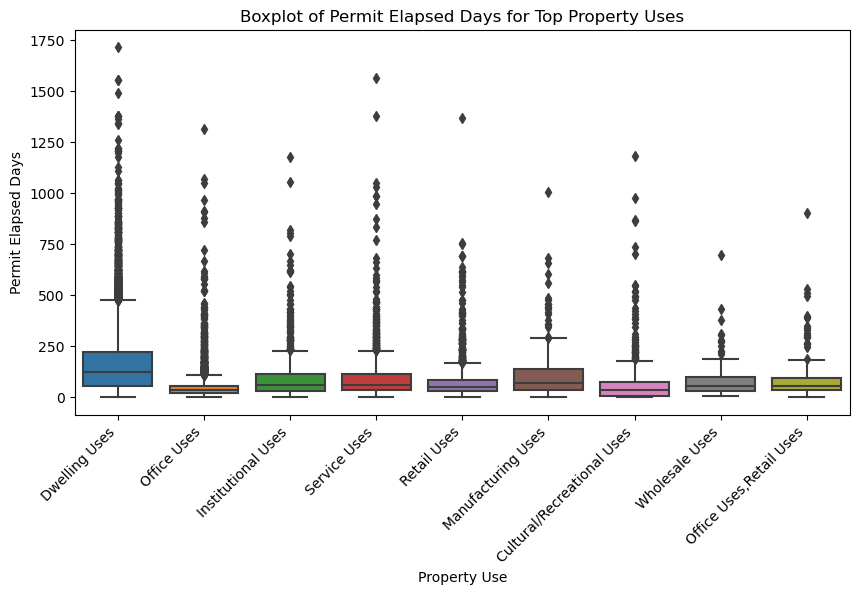

In [149]:
# Create a DataFrame with the top property uses
top_property_use = df.groupby(["PropertyUse"])["PermitElapsedDays"].describe().sort_values(by='count', ascending=False).head(9)

# Create a boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x='PropertyUse', y='PermitElapsedDays', data=df[df['PropertyUse'].isin(top_property_use.index)])
plt.xticks(rotation=45, ha='right')
plt.title('Boxplot of Permit Elapsed Days for Top Property Uses')
plt.xlabel('Property Use')
plt.ylabel('Permit Elapsed Days')
plt.show()

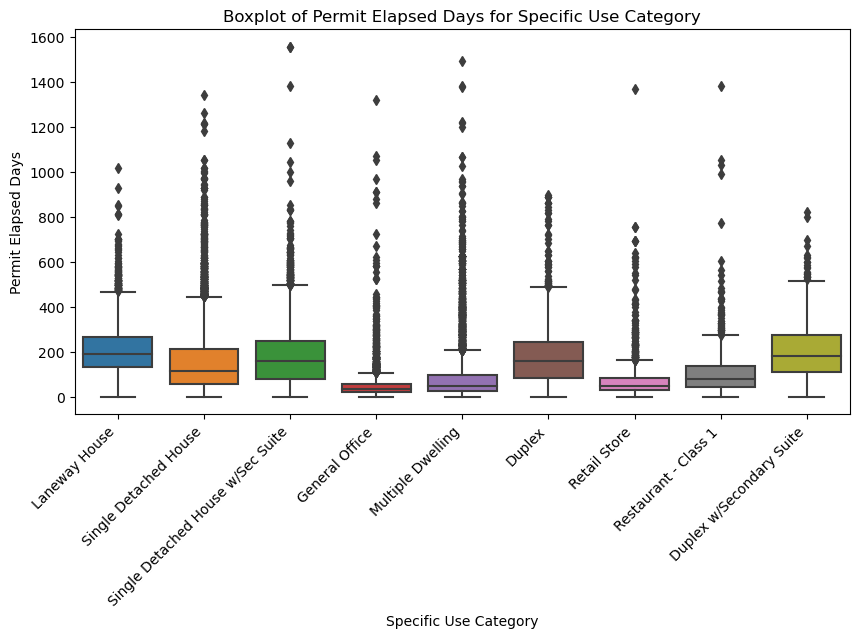

In [150]:
# Create a DataFrame with the top property uses
top_specific_use = df.groupby(["SpecificUseCategory"])["PermitElapsedDays"].describe().sort_values(by='count', ascending=False).head(9)

# Create a boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x='SpecificUseCategory', y='PermitElapsedDays', data=df[df['SpecificUseCategory'].isin(top_specific_use.index)])
plt.xticks(rotation=45, ha='right')
plt.title('Boxplot of Permit Elapsed Days for Specific Use Category')
plt.xlabel('Specific Use Category')
plt.ylabel('Permit Elapsed Days')
plt.show()

In [151]:
from scipy.stats import ttest_ind

# Choose two property use categories for comparison
category_A = "Dwelling Uses"
category_B = "Office Uses"

# Extract the permit elapsed days for the chosen categories
group_A = df[df["PropertyUse"] == category_A]["PermitElapsedDays"]
group_B = df[df["PropertyUse"] == category_B]["PermitElapsedDays"]

# Perform the t-test
statistic, p_value = ttest_ind(group_A, group_B, equal_var=False)

# Display the results
print(f"T-statistic: {statistic}")
print(f"P-value: {p_value}")

# Check the significance level (e.g., 0.05)
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between Dwelling Uses and Office Uses.")
else:
    print("Fail to reject the null hypothesis: No significant difference.")


T-statistic: 80.7056945878716
P-value: 0.0
Reject the null hypothesis: There is a significant difference between Dwelling Uses and Office Uses.


**Insights:**
1) There is a positive correlation between higher property values and longer waiting times for permits, which is reasonable as more expensive projects often require more thorough analysis.
2) The average waiting time for a new building permit is 248 days, while for Addition/Alteration, it is 81 days. This disparity is expected, considering that new building projects typically involve more complexities.
3) Dwelling Uses exhibit an average waiting time of 159 days, significantly higher than other property uses such as Office Uses, which averages 52 days. This discrepancy may be attributed to a higher volume of Dwelling Uses applications, potentially leading to a shortage of staff resources. Also, the municipal department may prioritize certain types of permits over others based on various criteria. If Dwelling Uses are considered lower priority or face delays in processing, it could lead to longer waiting times.

## Time Series

### Seasonality

Let's explore **seasonality** across multiple years for **created date.**

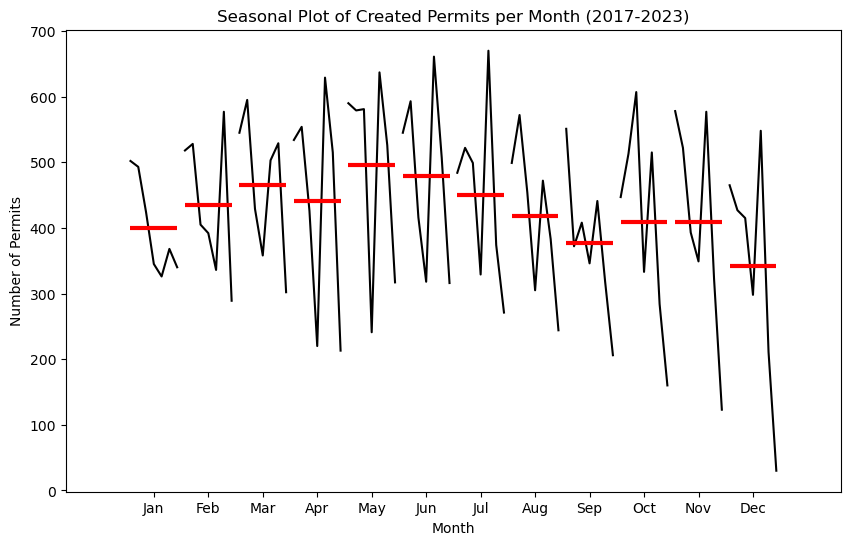

In [152]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot

# Assuming df is your DataFrame with 'PermitNumberCreatedDate' as a datetime index
df['PermitNumberCreatedDate'] = pd.to_datetime(df['PermitNumberCreatedDate'])
df_season = df.copy()
df_season = df_season[df_season["PermitNumberCreatedDate"].dt.year != 2013]
df_season = df_season[df_season["PermitNumberCreatedDate"].dt.year != 2014]
df_season = df_season[df_season["PermitNumberCreatedDate"].dt.year != 2015]
df_season = df_season[df_season["PermitNumberCreatedDate"].dt.year != 2016]

df_season.set_index('PermitNumberCreatedDate', inplace=True)

# Resample data to get the count of permits per month
monthly_counts = df_season.resample('M').size()

# Create a seasonal plot
fig, ax = plt.subplots(figsize=(10, 6))
month_plot(monthly_counts, ax=ax)

plt.title('Seasonal Plot of Created Permits per Month (2017-2023)')
plt.xlabel('Month')
plt.ylabel('Number of Permits')
plt.show()


**Insights:**

The red bars show the average for the given month across all years, while each black line represent an individual month and the progression of values across the years. 

I observe a consistent upward trend in monthly permit applications, with May and June consistently exhibiting the highest numbers on average. The sharp decline in the middle can be attributed to the impact of the Covid lockdown. Surprisingly, the year 2023 shows an even lower number of applications compared to the Covid period.

Let's explore **seasonality** across multiple years for **issued date.**

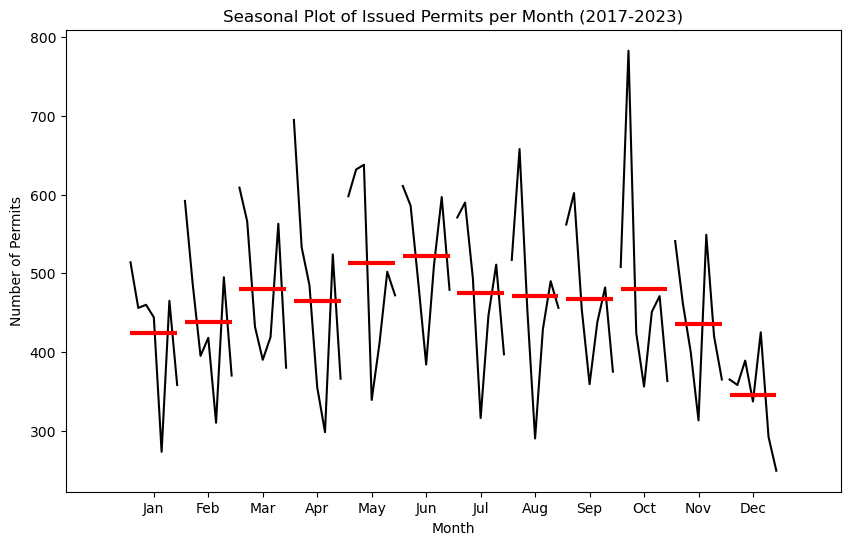

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot

# Assuming df is your DataFrame with 'IssueDate' as a datetime index
df['IssueDate'] = pd.to_datetime(df['IssueDate'])
df_season = df.copy()
df_season.set_index('IssueDate', inplace=True)

# Resample data to get the count of permits per month
monthly_counts1 = df_season.resample('M').size()

# Create a seasonal plot
fig, ax = plt.subplots(figsize=(10, 6))
month_plot(monthly_counts1, ax=ax)

plt.title('Seasonal Plot of Issued Permits per Month (2017-2023)')
plt.xlabel('Month')
plt.ylabel('Number of Permits')
plt.show()


**Insights:**

I observe a consistent upward trend in monthly issued permits, with May and June consistently exhibiting the highest numbers on average. The sharp decline in the middle can be attributed to the impact of the Covid lockdown. The year 2023 shows an  lower number of issued permits, due the lower number of applications.


### Trend-Seasonal Decomposition for PermitNumberCreatedDate

In [154]:
# decompose the time series
from statsmodels.api import tsa # time series analysis
decomposition = tsa.seasonal_decompose(monthly_counts, model='additive')

In [155]:
# add the decomposition data

monthly_counts["Trend"] = decomposition.trend
monthly_counts["Seasonal"] = decomposition.seasonal
monthly_counts["Residual"] = decomposition.resid

monthly_counts.head(50)

PermitNumberCreatedDate
2017-01-31 00:00:00    502
2017-02-28 00:00:00    518
2017-03-31 00:00:00    545
2017-04-30 00:00:00    534
2017-05-31 00:00:00    590
2017-06-30 00:00:00    545
2017-07-31 00:00:00    484
2017-08-31 00:00:00    499
2017-09-30 00:00:00    551
2017-10-31 00:00:00    447
2017-11-30 00:00:00    578
2017-12-31 00:00:00    465
2018-01-31 00:00:00    493
2018-02-28 00:00:00    528
2018-03-31 00:00:00    595
2018-04-30 00:00:00    554
2018-05-31 00:00:00    579
2018-06-30 00:00:00    593
2018-07-31 00:00:00    522
2018-08-31 00:00:00    572
2018-09-30 00:00:00    372
2018-10-31 00:00:00    513
2018-11-30 00:00:00    522
2018-12-31 00:00:00    427
2019-01-31 00:00:00    424
2019-02-28 00:00:00    405
2019-03-31 00:00:00    429
2019-04-30 00:00:00    426
2019-05-31 00:00:00    581
2019-06-30 00:00:00    416
2019-07-31 00:00:00    499
2019-08-31 00:00:00    454
2019-09-30 00:00:00    408
2019-10-31 00:00:00    607
2019-11-30 00:00:00    393
2019-12-31 00:00:00    415
2020

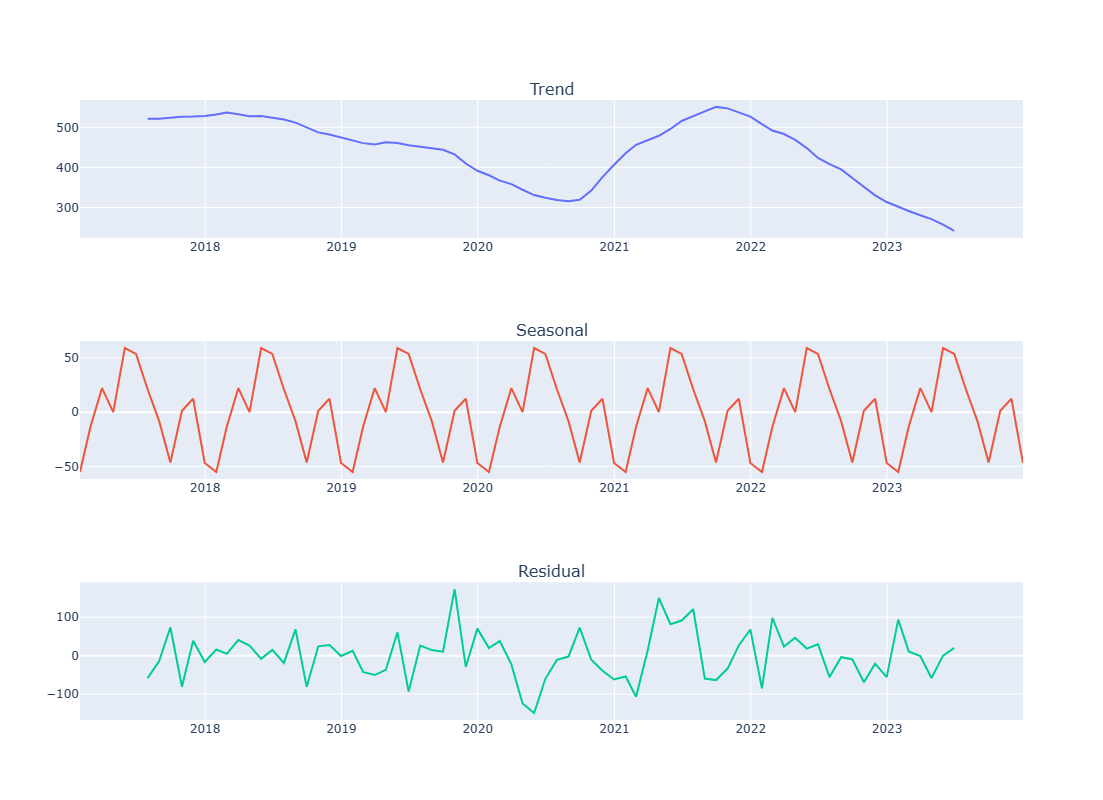

In [156]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go
cols = ["Trend", "Seasonal", "Residual"]

fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=monthly_counts.index, y=monthly_counts[col]),
        row=i+1,
        col=1
    )

fig.update_layout(height=800, width=1200, showlegend=False)
fig.show()

In [157]:
df.head()

,PermitNumber,PermitNumberCreatedDate,IssueDate,PermitElapsedDays,ProjectValue,TypeOfWork,ProjectDescription,Applicant,PropertyUse,SpecificUseCategory,IssueYear,GeoLocalArea,Geom,YearMonth,geo_point_2d
0,DB-2023-00041,2023-01-05,2023-04-28,113,198847.5,New Building,Low Density Housing - New Building - To constr...,Shalindro Dosanjh,Dwelling Uses,Laneway House,2023,Victoria-Fraserview,"{""coordinates"": [-123.0755831, 49.2165995], ""t...",2023-04,"49.2165995, -123.0755831"
1,BP-2023-00049,2023-01-06,2023-03-29,82,0.0,Salvage and Abatement,Low Density Housing - Salvage and Abatement - ...,John Keen DBA: Farpoint Architectural Inc.,Dwelling Uses,Single Detached House,2023,Kensington-Cedar Cottage,"{""coordinates"": [-123.081827, 49.244843], ""typ...",2023-03,"49.244843, -123.081827"
2,DB-2023-00050,2023-01-06,2023-09-12,249,1068777.5,New Building,Low Density Housing - New Building - To constr...,Embark Homes DBA: Embark Homes LTD,Dwelling Uses,Single Detached House w/Sec Suite,2023,Oakridge,"{""coordinates"": [-123.1079161, 49.2270346], ""t...",2023-09,"49.2270346, -123.1079161"
3,DB-2023-00064,2023-01-06,2023-10-04,271,155030.0,New Building,Low Density Housing - New Building - To constr...,Wayne Ng DBA: Skymark Engineering Ltd,Dwelling Uses,Laneway House,2023,Sunset,"{""coordinates"": [-123.1041746, 49.2170343], ""t...",2023-10,"49.2170343, -123.1041746"
5,BP-2023-00088,2023-01-09,2023-11-07,302,303592.0,Addition / Alteration,Field Review - Addition / Alteration - Structu...,Ian Duff DBA: Polycrete,Office Uses,General Office,2023,Kitsilano,"{""coordinates"": [-123.1470757, 49.271989], ""ty...",2023-11,"49.271989, -123.1470757"


### Trend-Seasonal Decomposition for IssueDate

In [158]:
monthly_counts1.head(4)

IssueDate
2017-01-31    514
2017-02-28    592
2017-03-31    609
2017-04-30    695
Freq: M, dtype: int64

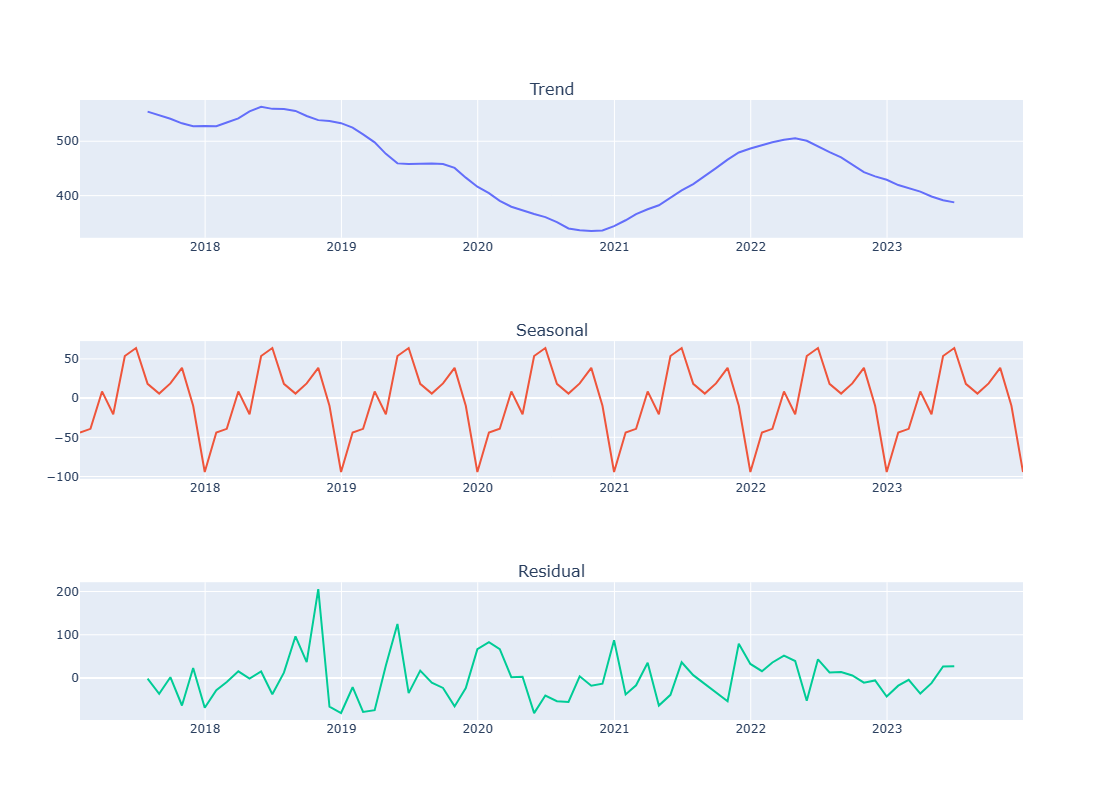

In [159]:
# decompose the time series
from statsmodels.api import tsa # time series analysis

decomposition = tsa.seasonal_decompose(monthly_counts1, model='additive')
# add the decomposition data

monthly_counts1["Trend"] = decomposition.trend
monthly_counts1["Seasonal"] = decomposition.seasonal
monthly_counts1["Residual"] = decomposition.resid

from plotly.subplots import make_subplots
import plotly.graph_objs as go
cols = ["Trend", "Seasonal", "Residual"]

fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=monthly_counts1.index, y=monthly_counts1[col]),
        row=i+1,
        col=1
    )

fig.update_layout(height=800, width=1200, showlegend=False)
fig.show()

**Insight:**

After experiencing a decline during the COVID-19 period, the number of permit applications exhibited a subsequent increase around the beginning of 2022. Surprisingly, in 2023, the application count dropped even lower than during the COVID-19 period. It's important to note that the decrease in issued permits in 2023 is directly tied to the overall low level of applications rather than any issues related to permit approval.

# EDA Conclusion

The analysis of permit data reveals valuable insights into the dynamics of construction activities and the permit application process in the given dataset.

**General Insights:**

   **Property Usage and Permit Types:**
   
- Predominantly, permits are issued for Dwelling Uses (single detached house, duplex) and Office Uses (General office). The number of permits for Dwelling Uses is approximately five times higher than that for Office Uses.
        
- Addition/Alteration is the most common permit type, outnumbering New Building permits by a factor of five.

**Yearly Trends:**

- The year 2020 witnessed the lowest number of issued permits, possibly attributed to the impact of COVID-19 lockdown measures.

- The Downtown area stands out with the highest number of issued permits, indicating increased construction or renovation activity.

**Processing Times:**

- On average, the waiting time for permit issuance is 136 days. However, the presence of numerous outliers suggests significant variations in processing times.

**Relationships and Correlations:**

   **Property Values and Waiting Times:**

- There is a positive correlation between higher property values and longer waiting times for permits, which is reasonable as more expensive projects often require more thorough analysis.

- The average waiting time for a new building permit is 248 days, while for Addition/Alteration, it is 81 days. This disparity is expected, considering that new building projects typically involve more complexities.

- Dwelling Uses exhibit an average waiting time of 159 days, significantly higher than other property uses such as Office Uses, which averages 52 days. This discrepancy may be attributed to a higher volume of Dwelling Uses applications, potentially leading to a shortage of staff resources.

**Seasonal Trends:**

   **Monthly Permit Applications:**

- There is a consistent upward trend in monthly permit applications, with May and June consistently exhibiting the highest numbers on average.

- The sharp decline in the middle can be attributed to the impact of the Covid lockdown.

- Surprisingly, the year 2023 shows an even lower number of applications compared to the Covid period.

**Monthly Issued Permits:**

- There is a consistent upward trend in monthly issued permits, with May and June consistently exhibiting the highest numbers on average.

- The sharp decline in the middle can be attributed to the impact of the Covid lockdown.

- The year 2023 shows an even lower number of issued permits compared to the Covid period, due to the lower number of applications.

**Overall Insights:**

After experiencing a decline during the COVID-19 period, the number of permit applications exhibited a subsequent increase around the beginning of 2022. However, surprisingly, in 2023, the application count dropped even lower than during the COVID-19 period. It's important to note that the decrease in issued permits in 2023 is directly tied to the overall low level of applications rather than any issues related to permit approval.

In [160]:
df.head()

,PermitNumber,PermitNumberCreatedDate,IssueDate,PermitElapsedDays,ProjectValue,TypeOfWork,ProjectDescription,Applicant,PropertyUse,SpecificUseCategory,IssueYear,GeoLocalArea,Geom,YearMonth,geo_point_2d
0,DB-2023-00041,2023-01-05,2023-04-28,113,198847.5,New Building,Low Density Housing - New Building - To constr...,Shalindro Dosanjh,Dwelling Uses,Laneway House,2023,Victoria-Fraserview,"{""coordinates"": [-123.0755831, 49.2165995], ""t...",2023-04,"49.2165995, -123.0755831"
1,BP-2023-00049,2023-01-06,2023-03-29,82,0.0,Salvage and Abatement,Low Density Housing - Salvage and Abatement - ...,John Keen DBA: Farpoint Architectural Inc.,Dwelling Uses,Single Detached House,2023,Kensington-Cedar Cottage,"{""coordinates"": [-123.081827, 49.244843], ""typ...",2023-03,"49.244843, -123.081827"
2,DB-2023-00050,2023-01-06,2023-09-12,249,1068777.5,New Building,Low Density Housing - New Building - To constr...,Embark Homes DBA: Embark Homes LTD,Dwelling Uses,Single Detached House w/Sec Suite,2023,Oakridge,"{""coordinates"": [-123.1079161, 49.2270346], ""t...",2023-09,"49.2270346, -123.1079161"
3,DB-2023-00064,2023-01-06,2023-10-04,271,155030.0,New Building,Low Density Housing - New Building - To constr...,Wayne Ng DBA: Skymark Engineering Ltd,Dwelling Uses,Laneway House,2023,Sunset,"{""coordinates"": [-123.1041746, 49.2170343], ""t...",2023-10,"49.2170343, -123.1041746"
5,BP-2023-00088,2023-01-09,2023-11-07,302,303592.0,Addition / Alteration,Field Review - Addition / Alteration - Structu...,Ian Duff DBA: Polycrete,Office Uses,General Office,2023,Kitsilano,"{""coordinates"": [-123.1470757, 49.271989], ""ty...",2023-11,"49.271989, -123.1470757"


# Feature Engineering

## Drop columns

The following columns can be dropped as they are not crucial for the prediction.

PermitNumber: This feature will not be used in the analysis.

YearMonth: This feature will not be used in the analysis.

Geom: This feature will not be used as it duplicates information present in geo_point_2d.

In [161]:
column_to_drop = ['IssueYear', 'IssueDate','PermitNumber', 'YearMonth', 'Geom']

baseline_df = df.drop(columns=column_to_drop)

## PermitNumberCreatedDate

Let's explore the datetime columns and conduct feature engineering. The IssueDate itself may not be crucial and I dropped it above, but extracting the month and date as separate features from PermitNumberCreatedDate could enhance predictive modeling.

In [162]:
baseline_df.select_dtypes('datetime').head()

,PermitNumberCreatedDate
0,2023-01-05
1,2023-01-06
2,2023-01-06
3,2023-01-06
5,2023-01-09


The month_sin and month_cos features are used to capture the cyclical nature of time, specifically the month of the year. By encoding the month in this way, you're representing it as a point on a unit circle, where January and December are close together. This encoding helps the model to understand the periodicity of time features like month in a more meaningful way compared to simply using integer labels for months.

In [163]:
# Extract the month from the date
baseline_df['Month'] = baseline_df['PermitNumberCreatedDate'].dt.month

baseline_df['Month_sin'] = np.sin(2 * np.pi * baseline_df['Month'] / 12)
baseline_df['Month_cos'] = np.cos(2 * np.pi * baseline_df['Month'] / 12)
baseline_df = baseline_df.drop(columns=['PermitNumberCreatedDate', 'Month'])

## Non-numeric columns

Let's examine non-numeric columns and perform feature engineering on them.

In [164]:
# inspect non-numeric columns
baseline_df.select_dtypes('object').head()

,TypeOfWork,ProjectDescription,Applicant,PropertyUse,SpecificUseCategory,GeoLocalArea,geo_point_2d
0,New Building,Low Density Housing - New Building - To constr...,Shalindro Dosanjh,Dwelling Uses,Laneway House,Victoria-Fraserview,"49.2165995, -123.0755831"
1,Salvage and Abatement,Low Density Housing - Salvage and Abatement - ...,John Keen DBA: Farpoint Architectural Inc.,Dwelling Uses,Single Detached House,Kensington-Cedar Cottage,"49.244843, -123.081827"
2,New Building,Low Density Housing - New Building - To constr...,Embark Homes DBA: Embark Homes LTD,Dwelling Uses,Single Detached House w/Sec Suite,Oakridge,"49.2270346, -123.1079161"
3,New Building,Low Density Housing - New Building - To constr...,Wayne Ng DBA: Skymark Engineering Ltd,Dwelling Uses,Laneway House,Sunset,"49.2170343, -123.1041746"
5,Addition / Alteration,Field Review - Addition / Alteration - Structu...,Ian Duff DBA: Polycrete,Office Uses,General Office,Kitsilano,"49.271989, -123.1470757"


In [165]:
# check the number of unique categories in each non-numeric column to determine of OHE is appropriate
baseline_df.select_dtypes('object').nunique()

TypeOfWork                 6
ProjectDescription     36206
Applicant               9169
PropertyUse              140
SpecificUseCategory      786
GeoLocalArea              22
geo_point_2d           19849
dtype: int64

**Summary:**

    TypeOfWork: One Hot Encoding is recommended since there are only 6 types of work.

    ProjectDescription: Utilize Bag-of-Words (Count) for NLP analysis on project descriptions.

    Applicant: Apply Bag-of-Words (Count) technique to process applicant information.

    PropertyUse: Preprocess by selecting the top 12 most frequent property uses; replace other categories with 'Others'. Follow with One Hot Encoding.

    SpecificUseCategory: Preprocess by selecting the top 22 most frequent specific use categories; replace other categories with 'Others'. Proceed with One Hot Encoding.

    GeoLocalArea: Perform One Hot Encoding to handle categorical data.
    
    geo_point_2d: Split into separate columns for latitudes and longitudes for further analysis. 

### geo_point_2d

In [166]:
# Split the 'geo_point_2d' column into two separate columns
baseline_df[['Latitude', 'Longitude']] = baseline_df['geo_point_2d'].str.split(', ', expand=True).astype(float)

# Drop the original 'geo_point_2d' column if needed
baseline_df = baseline_df.drop(columns=['geo_point_2d'])

### PropertyUse (One Hot Encoding)

In [167]:
# Get the top 12 categories
top_categories = baseline_df['PropertyUse'].value_counts().nlargest(12).index

# Replace categories not in the top 12 with 'Others'
baseline_df['PropertyUse'] = baseline_df['PropertyUse'].apply(lambda x: x if x in top_categories else 'Others')

In [168]:
baseline_df['PropertyUse'].unique()

array(['Dwelling Uses', 'Office Uses', 'Institutional Uses',
       'Service Uses', 'Retail Uses', 'Parking Uses', 'Others',
       'Manufacturing Uses', 'Cultural/Recreational Uses',
       'Wholesale Uses', 'Transportation and Storage Uses',
       'Office Uses,Retail Uses', 'Dwelling Uses,Retail Uses'],
      dtype=object)

### SpecificUseCategory (One Hot Encoding)

In [169]:
# Get the top 12 categories
top_categories = baseline_df['SpecificUseCategory'].value_counts().nlargest(22).index

# Replace categories not in the top 12 with 'Others'
baseline_df['SpecificUseCategory'] = baseline_df['SpecificUseCategory'].apply(lambda x: x if x in top_categories else 'Others')

In [170]:
baseline_df['GeoLocalArea'].unique()

array(['Victoria-Fraserview', 'Kensington-Cedar Cottage', 'Oakridge',
       'Sunset', 'Kitsilano', 'West End', 'Mount Pleasant', 'Kerrisdale',
       'West Point Grey', 'Dunbar-Southlands', 'Downtown', 'Riley Park',
       'Fairview', 'Marpole', 'Renfrew-Collingwood', 'Arbutus Ridge',
       'Strathcona', 'Hastings-Sunrise', 'Shaughnessy', 'Killarney',
       'Grandview-Woodland', 'South Cambie'], dtype=object)

Apply OHE to `TypeOfWork`,`PropertyUse`,`SpecificUseCategory`, `GeoLocalArea` non-numeric features at the same time.

In [171]:
ohe = OneHotEncoder()
column_to_encode = ['TypeOfWork','PropertyUse','SpecificUseCategory', 'GeoLocalArea']

encoded_matrix = ohe.fit_transform(baseline_df[column_to_encode])

# reconstruct a dataframe using
ohe_df=pd.DataFrame(encoded_matrix.toarray(),columns=ohe.get_feature_names(),dtype=int) # specify datatype as integer since all columns are binary
ohe_df.index = baseline_df.index

In [172]:
# Drop the original column from the original DataFrame
baseline_df = baseline_df.drop(columns=column_to_encode)

# Concatenate the original DataFrame with the one-hot encoded DataFrame
baseline_df = baseline_df.join(ohe_df)

In [173]:
baseline_df.columns

Index(['PermitElapsedDays', 'ProjectValue', 'ProjectDescription', 'Applicant',
       'Month_sin', 'Month_cos', 'Latitude', 'Longitude',
       'x0_Addition / Alteration', 'x0_Demolition / Deconstruction',
       'x0_New Building', 'x0_Outdoor Uses (No Buildings Proposed)',
       'x0_Salvage and Abatement', 'x0_Temporary Building / Structure',
       'x1_Cultural/Recreational Uses', 'x1_Dwelling Uses',
       'x1_Dwelling Uses,Retail Uses', 'x1_Institutional Uses',
       'x1_Manufacturing Uses', 'x1_Office Uses', 'x1_Office Uses,Retail Uses',
       'x1_Others', 'x1_Parking Uses', 'x1_Retail Uses', 'x1_Service Uses',
       'x1_Transportation and Storage Uses', 'x1_Wholesale Uses',
       'x2_Barber Shop or Beauty Salon', 'x2_Beauty and Wellness Centre',
       'x2_Duplex', 'x2_Duplex w/Secondary Suite', 'x2_Dwelling Unit',
       'x2_Financial Institution', 'x2_General Office',
       'x2_Health Care Office', 'x2_Hospital',
       'x2_Infill Single Detached House', 'x2_Laneway House

### ProjectDescription (The Bag-of-Words model)

ProjectDescription contains detailed text about the project that can be used in the model using the Bag-of-Words model.

In [174]:
# instantiating the independent and dependent variables
X = baseline_df.drop(columns="PermitElapsedDays")
y = baseline_df["PermitElapsedDays"]

In [175]:
# performing a train_test_split to better evaluate our model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=42)

In [176]:
X_test.columns

Index(['ProjectValue', 'ProjectDescription', 'Applicant', 'Month_sin',
       'Month_cos', 'Latitude', 'Longitude', 'x0_Addition / Alteration',
       'x0_Demolition / Deconstruction', 'x0_New Building',
       'x0_Outdoor Uses (No Buildings Proposed)', 'x0_Salvage and Abatement',
       'x0_Temporary Building / Structure', 'x1_Cultural/Recreational Uses',
       'x1_Dwelling Uses', 'x1_Dwelling Uses,Retail Uses',
       'x1_Institutional Uses', 'x1_Manufacturing Uses', 'x1_Office Uses',
       'x1_Office Uses,Retail Uses', 'x1_Others', 'x1_Parking Uses',
       'x1_Retail Uses', 'x1_Service Uses',
       'x1_Transportation and Storage Uses', 'x1_Wholesale Uses',
       'x2_Barber Shop or Beauty Salon', 'x2_Beauty and Wellness Centre',
       'x2_Duplex', 'x2_Duplex w/Secondary Suite', 'x2_Dwelling Unit',
       'x2_Financial Institution', 'x2_General Office',
       'x2_Health Care Office', 'x2_Hospital',
       'x2_Infill Single Detached House', 'x2_Laneway House',
       'x2_Multipl

**What tokenizer and text cleaning steps do I include?**

Remove punctuation;

Set to the lower case;

Remove the common stop words;

Perform lemmatization;

Perform stemming;

In [177]:
ENGLISH_STOP_WORDS = stopwords.words('english')
nltk.download('wordnet')

stemmer = nltk.stem.PorterStemmer()
lemm = WordNetLemmatizer()

def my_tokenizer(sentence):
    
    sentence = sentence.replace('\r', ' ')
    sentence = sentence.replace('\n', ' ')
    
    # remove punctuation
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'')

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    listoflemmatize_words = []
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            lemmatized_word = lemm.lemmatize(word, wordnet.VERB)
            listoflemmatize_words.append(lemmatized_word)
        
    for word in listoflemmatize_words:
        stemmed_word = stemmer.stem(word)
        listofstemmed_words.append(stemmed_word)
    
    return listofstemmed_words

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tatya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Transform the ProjectDescription columns using a CountVectorizer with the following settings: 
- set to lower case because it helps in treating words with different cases as the same, preventing the model from considering them as distinct features;
- use the tokinizer I defined above;
- use unigrams and bigrams as features in the analysis. Bigrams (consecutive pairs of words) as features provides a more comprehensive representation of the text;
- maximize the number of features at 500 because restricting the feature set to 500 ensures a balance between capturing relevant information and maintaining model efficiency;
- tokens used <10 times are dropped from the vocabulary because it can help eliminate noise from the dataset;y.

In [178]:
bagofwords_pr = CountVectorizer(min_df=10,
                             max_features=500,
                             tokenizer = my_tokenizer,
                             lowercase=True,
                             ngram_range=(1, 3))

bagofwords_pr.fit(X_train["ProjectDescription"])

X_train_pr = bagofwords_pr.transform(X_train["ProjectDescription"])
X_test_pr = bagofwords_pr.transform(X_test["ProjectDescription"])

C:\Users\tatya\anaconda3\envs\plotly_bokeh\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [179]:
# Drop the column 
columns_to_drop = ['ProjectDescription']

# Drop multiple columns in-place
X_train.drop(columns=columns_to_drop, inplace=True)
X_test.drop(columns=columns_to_drop, inplace=True)

C:\Users\tatya\AppData\Local\Temp\ipykernel_11364\3464179820.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\tatya\AppData\Local\Temp\ipykernel_11364\3464179820.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [180]:
# Add the prefix pd for ProjectDescription for columns
cols = [f'pd_{word}' for word in bagofwords_pr.get_feature_names()]

X_train_pr = pd.DataFrame(columns=cols, data=X_train_pr.toarray(), index=X_train.index)

# Join the original traning dataset and Project Description bag of words.
X_train_extended_with_pr = pd.concat([X_train, X_train_pr], axis=1)

In [181]:
# Join the original test dataset and positive bag of words.
X_test_pr = pd.DataFrame(columns=cols, data=X_test_pr.toarray(), index=X_test.index)
X_test_extended_with_pr = pd.concat([X_test, X_test_pr], axis=1)

**Top 30 most frequently occurring words in ProjectDescription:**

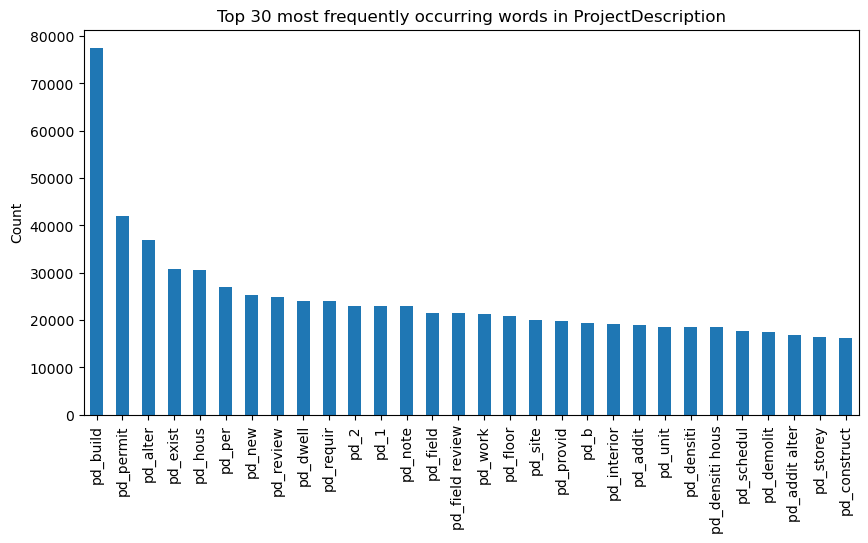

In [182]:
word_counts_pos = pd.DataFrame(
    {"counts": X_train_pr.sum(axis=0)}
).sort_values("counts", ascending=False)

word_counts_pos.head(30).plot(kind="bar", figsize=(10, 5), legend=False)
plt.title("Top 30 most frequently occurring words in ProjectDescription")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

### Applicant (The Bag-of-Words model)

The same process above is applied to the Applicant column.

In [183]:
bagofwords_ap = CountVectorizer(min_df=10,
                             max_features=500,
                             tokenizer = my_tokenizer,
                             lowercase=True,
                             ngram_range=(1, 3))

bagofwords_ap.fit(X_train_extended_with_pr["Applicant"])

X_train_ap = bagofwords_ap.transform(X_train_extended_with_pr["Applicant"])
X_test_ap = bagofwords_ap.transform(X_test_extended_with_pr["Applicant"])

C:\Users\tatya\anaconda3\envs\plotly_bokeh\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [184]:
# Drop the column 
columns_to_drop = ['Applicant']

# Drop multiple columns in-place
X_train_extended_with_pr.drop(columns=columns_to_drop, inplace=True)
X_test_extended_with_pr.drop(columns=columns_to_drop, inplace=True)

In [185]:
# Add the prefix ap for Applicant for columns
cols = [f'ap_{word}' for word in bagofwords_ap.get_feature_names()]

X_train_ap = pd.DataFrame(columns=cols, data=X_train_ap.toarray(), index=X_train_extended_with_pr.index)

# Join the original traning dataset and Applicant bag of words.
X_train_extended_with_ap = pd.concat([X_train_extended_with_pr, X_train_ap], axis=1)

In [186]:
# Join the original test dataset and positive bag of words.
X_test_ap = pd.DataFrame(columns=cols, data=X_test_ap.toarray(), index=X_test_extended_with_pr.index)
X_test_extended_with_ap = pd.concat([X_test_extended_with_pr, X_test_ap], axis=1)

**Top 30 most frequently occurring words in Applicant:**

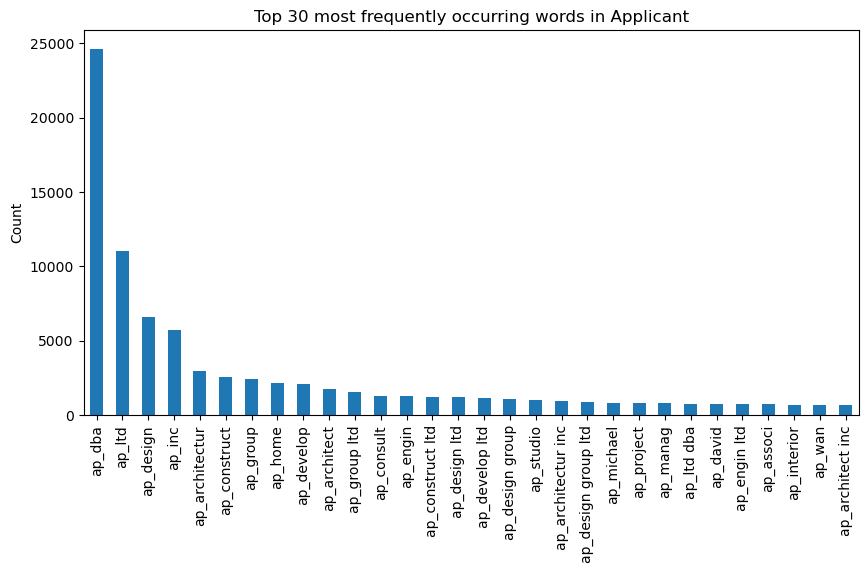

In [187]:
word_counts_pos = pd.DataFrame(
    {"counts": X_train_ap.sum(axis=0)}
).sort_values("counts", ascending=False)

word_counts_pos.head(30).plot(kind="bar", figsize=(10, 5), legend=False)
plt.title("Top 30 most frequently occurring words in Applicant")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [188]:
# Save the CountVectorizer model to a file
with open('bagofwords_ap_model.pkl', 'wb') as file:
    pickle.dump(bagofwords_ap, file)
    
# Save the CountVectorizer model to a file
with open('bagofwords_pr_model.pkl', 'wb') as file:
    pickle.dump(bagofwords_pr, file)

# Baseline models

For the base models, the linear regression, ridge regression and decision tree are trained without perfect tuning and cross-validation.

In [312]:
X_train = X_train_extended_with_ap
X_test = X_test_extended_with_ap

In [190]:
X_train = X_train.drop(X_train.filter(regex='^pd_').columns, axis=1)
X_test = X_test.drop(X_test.filter(regex='^pd_').columns, axis=1)
X_train = X_train.drop(X_train.filter(regex='^ap_').columns, axis=1)
X_test = X_test.drop(X_test.filter(regex='^ap_').columns, axis=1)

In [313]:
X_train

,ProjectValue,Month_sin,Month_cos,Latitude,Longitude,x0_Addition / Alteration,x0_Demolition / Deconstruction,x0_New Building,x0_Outdoor Uses (No Buildings Proposed),x0_Salvage and Abatement,...,ap_wu,ap_wyli,ap_wyli architect,ap_wyli architect inc,ap_yan,ap_yee,ap_yuen,ap_yuen dba,ap_yuen dba dwg,ap_zhang
31402,717212.5,-8.660254e-01,0.500000,49.282096,-123.029909,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
24582,173750.0,-8.660254e-01,-0.500000,49.244851,-123.036701,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
15857,195000.0,-2.449294e-16,1.000000,49.214045,-123.113618,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18749,5000.0,-8.660254e-01,-0.500000,49.269418,-123.213112,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
33874,0.0,-2.449294e-16,1.000000,49.252602,-123.092643,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6379,5000.0,-2.449294e-16,1.000000,49.283167,-123.120909,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11566,50000.0,8.660254e-01,0.500000,49.290613,-123.144253,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39095,200000.0,5.000000e-01,0.866025,49.266748,-123.102757,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
889,5000.0,-8.660254e-01,0.500000,49.270257,-123.152444,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Because I have a lot of outliers I use the Robust scaler.

In [315]:
# Instantiate the Robust scaler because I have a lot of outliers
SS = RobustScaler()

# Fit the scaler
SS.fit(X_train)

# Transform the training and test sets 
X_train_ss = SS.transform(X_train)
X_test_ss = SS.transform(X_test)

## LinearRegression

In [287]:
# 1. Instantiate the model
linear_regression_model = LinearRegression()

# 2. Fit the model
linear_regression_model.fit(X_train_ss, y_train)

# 3. Score on the training data 
print(linear_regression_model.score(X_train_ss, y_train))

# 4. Score on the testing data
print(linear_regression_model.score(X_test_ss, y_test))

# Make predictions on the training and testing data
y_train_pred = linear_regression_model.predict(X_train_ss)
y_test_pred = linear_regression_model.predict(X_test_ss)

0.4489157809925154
-2157561364561.1433


In [288]:
## Evaluate the model
print("Training Metrics:")
print("Mean Absolute Error:", mean_absolute_error(y_train, y_train_pred))
print("Mean Squared Error:", mean_squared_error(y_train, y_train_pred))
print("R-squared:", r2_score(y_train, y_train_pred))

print("\nTesting Metrics:")
print("Mean Absolute Error:", mean_absolute_error(y_test, y_test_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_test_pred))
print("R-squared:", r2_score(y_test, y_test_pred))

Training Metrics:
Mean Absolute Error: 63.58662009663927
Mean Squared Error: 10625.515630485948
R-squared: 0.4489157809925154

Testing Metrics:
Mean Absolute Error: 3217652.105463328
Mean Squared Error: 3.9972420214121304e+16
R-squared: -2157561364561.1433


Training Metrics:

    Mean Absolute Error (MAE): On average, the baseline model's predictions on the training set are off by approximately 64 days.

    Mean Squared Error (MSE): The average squared difference between the model's predictions and the actual values on the training set is around  11026.

    R-squared: The R-squared value of approximately 0.42 indicates that around 42% of the variance in the 'PermitElapsedDays' variable is explained by model on the training set.

Testing Metrics:

    Mean Absolute Error (MAE): On average, the model's predictions on the testing set are off by approximately 64 days.

    Mean Squared Error (MSE): The average squared difference between your model's predictions and the actual values on the testing set is around 11252.

    R-squared: The R-squared value of approximately 0.39 indicates that around 39% of the variance in the 'PermitElapsedDays' variable is explained by the model on the testing set.

## Ridge model

Ridge regression is useful when multicollinearity is present among the predictors. Let's try that model.

In [289]:
# Create a Lasso regression model: 
ridge_model = Ridge(alpha=1.0) 

# Fit the model to the training data
ridge_model.fit(X_train_ss, y_train)

# Make predictions on the training and testing data
y_train_pred = ridge_model.predict(X_train_ss)
y_test_pred = ridge_model.predict(X_test_ss)

# Evaluate the model
print("Training Metrics:")
print("Mean Absolute Error:", mean_absolute_error(y_train, y_train_pred))
print("Mean Squared Error:", mean_squared_error(y_train, y_train_pred))
print("R-squared:", r2_score(y_train, y_train_pred))

print("\nTesting Metrics:")
print("Mean Absolute Error:", mean_absolute_error(y_test, y_test_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_test_pred))
print("R-squared:", r2_score(y_test, y_test_pred))

Training Metrics:
Mean Absolute Error: 63.60861934140836
Mean Squared Error: 10637.520070283106
R-squared: 0.44829317992916007

Testing Metrics:
Mean Absolute Error: 64.82842460540635
Mean Squared Error: 11090.68250445139
R-squared: 0.4013665434804936


In [196]:
# Save the model to a file
with open('model.pkl', 'wb') as file:
    pickle.dump(ridge_model, file)

# Save the model to a file
with open('robust_scaler.pkl', 'wb') as file:
    pickle.dump(SS, file)

## DecisionTreeRegressor model

In [297]:
# Create a DecisionTreeRegressor model
decision_tree_model = DecisionTreeRegressor(max_depth = 8, random_state=42)

# Fit the model to the training data
decision_tree_model.fit(X_train_ss, y_train)

# Make predictions on the training and testing data
y_train_pred = decision_tree_model.predict(X_train_ss)
y_test_pred = decision_tree_model.predict(X_test_ss)

# Evaluate the model
print("Training Metrics:")
print("Mean Absolute Error:", mean_absolute_error(y_train, y_train_pred))
print("Mean Squared Error:", mean_squared_error(y_train, y_train_pred))
print("R-squared:", r2_score(y_train, y_train_pred))

print("\nTesting Metrics:")
print("Mean Absolute Error:", mean_absolute_error(y_test, y_test_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_test_pred))
print("R-squared:", r2_score(y_test, y_test_pred))

Training Metrics:
Mean Absolute Error: 62.71437488562126
Mean Squared Error: 10354.74523908595
R-squared: 0.4629590796769477

Testing Metrics:
Mean Absolute Error: 63.88941534204774
Mean Squared Error: 11600.07065532124
R-squared: 0.37387168107298097


# Next steps...

There is room for improvement, as indicated by the MAE and MSE values. I want to explore additional feature engineering, hyperparameter tuning, cross-validation and consider more complex models to improve predictive performance.
 
Time series regression where I want to consider the time aspect (specifically the month):
1) Linear Regression with Time Features: Enhance a traditional linear regression model by including time-related features. For example, you can extract month-related features such as sine and cosine transforms of the month to capture seasonal patterns.

2) Seasonal Decomposition of Time Series (STL): Decompose the time series into trend, seasonal, and residual components using methods like Seasonal-Trend decomposition using LOESS (STL). Then, apply a regression model to the deseasonalized time series.

3) Autoregressive Integrated Moving Average (ARIMA): ARIMA models are popular for capturing time series patterns. They consist of autoregressive (AR), differencing (I), and moving average (MA) components. ARIMA models can be extended to include exogenous variables for regression.

4) Seasonal ARIMA (SARIMA): Extends ARIMA to include seasonality. SARIMA models are suitable when your time series exhibits recurring patterns over specific intervals.

5) XGBoost or LightGBM with Time Features: Gradient boosting algorithms like XGBoost or LightGBM can be effective for time series regression. Include time-related features to capture temporal patterns.

6) LSTM (Long Short-Term Memory) Neural Networks: For more complex and non-linear relationships, recurrent neural networks (RNNs) such as LSTM can be employed. LSTMs are especially useful for capturing long-term dependencies in time series data.

In [316]:
# Perform PCA for dimensionality reduction
pca = PCA(n_components=30)  # Set the number of components to retain
X_train_pca = pca.fit_transform(X_train_ss)
X_test_pca = pca.transform(X_test_ss)


In [317]:
# Get the explained variance ratios
explained_var_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_explained_var = np.cumsum(explained_var_ratio)

# Print the explained variance for each component and cumulative explained variance for the first 20 components
for i in range(65):
    print(f"Component {i + 1}: Explained Variance = {explained_var_ratio[i]:.4f}, Cumulative Explained Variance = {cumulative_explained_var[i]:.4f}")

Component 1: Explained Variance = 0.9326, Cumulative Explained Variance = 0.9326
Component 2: Explained Variance = 0.0138, Cumulative Explained Variance = 0.9463
Component 3: Explained Variance = 0.0068, Cumulative Explained Variance = 0.9531
Component 4: Explained Variance = 0.0028, Cumulative Explained Variance = 0.9560
Component 5: Explained Variance = 0.0024, Cumulative Explained Variance = 0.9584
Component 6: Explained Variance = 0.0022, Cumulative Explained Variance = 0.9606
Component 7: Explained Variance = 0.0020, Cumulative Explained Variance = 0.9626
Component 8: Explained Variance = 0.0016, Cumulative Explained Variance = 0.9642
Component 9: Explained Variance = 0.0013, Cumulative Explained Variance = 0.9655
Component 10: Explained Variance = 0.0013, Cumulative Explained Variance = 0.9667
Component 11: Explained Variance = 0.0011, Cumulative Explained Variance = 0.9678
Component 12: Explained Variance = 0.0010, Cumulative Explained Variance = 0.9688
Component 13: Explained V

IndexError: index 30 is out of bounds for axis 0 with size 30

<div id="container" style="position:relative;">
<div style="position:relative; float:right">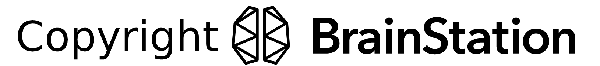
</div>
</div>


In [318]:
# Get the loadings
feature_names  = X_train.columns.tolist()
loadings = pca.components_
for i in range(65):
    component_loadings = loadings[i]
    main_variables = [feature_names[j] for j in range(len(feature_names)) if abs(component_loadings[j]) > 0.2]  # Adjust the threshold as needed
    print(f"Main variables for Component {i + 1}: {main_variables}")

Main variables for Component 1: ['ProjectValue']
Main variables for Component 2: []
Main variables for Component 3: []
Main variables for Component 4: ['pd_dwell', 'pd_suit']
Main variables for Component 5: ['pd_abat', 'pd_salvag', 'pd_salvag abat']
Main variables for Component 6: ['pd_demolit', 'pd_requir']
Main variables for Component 7: ['pd_1']
Main variables for Component 8: ['pd_b', 'pd_peng', 'pd_schedul', 'pd_schedul b']
Main variables for Component 9: ['pd_b', 'pd_per', 'pd_schedul']
Main variables for Component 10: ['pd_new']
Main variables for Component 11: ['pd_bp', 'pd_floor', 'pd_tenant']
Main variables for Component 12: ['pd_access', 'pd_new', 'pd_number']
Main variables for Component 13: ['pd_dwell', 'pd_new', 'pd_suit', 'pd_unit']
Main variables for Component 14: ['pd_demolit', 'pd_hous', 'pd_unit']
Main variables for Component 15: ['pd_dwell', 'pd_floor', 'pd_per', 'pd_unit', 'pd_upgrad']
Main variables for Component 16: ['pd_1', 'pd_floor']
Main variables for Compone

IndexError: index 30 is out of bounds for axis 0 with size 30

## Polynomial Regression

Overffiting for degree 3:
Training Metrics:
Mean Absolute Error: 11.303473210311534
Mean Squared Error: 985.6872067651686
R-squared: 0.948878088987291

Testing Metrics:
Mean Absolute Error: 527.613574812998
Mean Squared Error: 3134876.7324412437
R-squared: -168.2088916395058

In [311]:

# Define the degree of polynomial features
degree = 2

# Create a pipeline with PolynomialFeatures and Ridge Regression
model = make_pipeline(PolynomialFeatures(degree), Ridge())  # You can adjust the alpha parameter for Ridge regularization

# Fit the model to the training data
model.fit(X_train_pca, y_train)

# Make predictions on the training and testing data
y_train_pred = model.predict(X_train_pca)
y_test_pred = model.predict(X_test_pca)

# Evaluate the model
print("Training Metrics:")
print("Mean Absolute Error:", mean_absolute_error(y_train, y_train_pred))
print("Mean Squared Error:", mean_squared_error(y_train, y_train_pred))
print("R-squared:", r2_score(y_train, y_train_pred))

print("\nTesting Metrics:")
print("Mean Absolute Error:", mean_absolute_error(y_test, y_test_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_test_pred))
print("R-squared:", r2_score(y_test, y_test_pred))

Training Metrics:
Mean Absolute Error: 64.92269980882926
Mean Squared Error: 11268.024935362431
R-squared: 0.4155925286632818

Testing Metrics:
Mean Absolute Error: 66.09745074179739
Mean Squared Error: 11653.896861606047
R-squared: 0.37096634428178954


In [268]:
# Define the XGBoost model
model = xgb.XGBRegressor()

# Fit the model to the training data
model.fit(X_train_ss, y_train)

# Make predictions on the training and testing data
y_train_pred = model.predict(X_train_ss)
y_test_pred = model.predict(X_test_ss)

# Evaluate the model
print("Training Metrics:")
print("Mean Absolute Error:", mean_absolute_error(y_train, y_train_pred))
print("Mean Squared Error:", mean_squared_error(y_train, y_train_pred))
print("R-squared:", r2_score(y_train, y_train_pred))

print("\nTesting Metrics:")
print("Mean Absolute Error:", mean_absolute_error(y_test, y_test_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_test_pred))
print("R-squared:", r2_score(y_test, y_test_pred))

Training Metrics:
Mean Absolute Error: 50.66874428136876
Mean Squared Error: 6216.568413822754
R-squared: 0.6775824469723704

Testing Metrics:
Mean Absolute Error: 59.705853745684784
Mean Squared Error: 10055.435548231966
R-squared: 0.45724529246678847


Default Parameters:
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'eval_metric': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


# todo: play with PCA, pipeline and grid, pick the parametrs 
# todo: finish UI  starts 3:30
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5],
    'min_child_weight': [1, 5],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'gamma': [0, 0.1, 0.2],
    'n_estimators': [1000],
    'reg_alpha': [0, 0.1, 1.0],
    'reg_lambda': [0, 0.1, 1.0]
}

param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_child_weight': [1],
    'subsample': [0.7],
    'colsample_bytree': [0.7],
    'gamma': [0, 0.1],
    'n_estimators': [500],
    'reg_alpha': [0.1, 1.0]
}

In [319]:
import time


# Record start time
start_time = time.time()

param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5],
    'min_child_weight': [3, 5],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'gamma': [0, 0.1, 0.2],
    'n_estimators': [100],
    'reg_alpha': [0, 0.1, 1.0],
    'reg_lambda': [0, 0.1, 1.0]
}

# Define the XGBRegressor 
xgb_model = xgb.XGBRegressor()

# Perform Grid Search with 3-fold cross-validation and early stopping
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train_ss, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Record end time
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time

print("Time taken for running the model:", elapsed_time, "seconds")

Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0}
Time taken for running the model: 53990.3233332634 seconds


I run the model for 100,300,500,1000 -> overfitting 

In [320]:
# Train the model with best parameters
best_xgb_model = xgb.XGBRegressor(**best_params)
best_xgb_model.fit(X_train_ss, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [321]:
# Make predictions on the training and testing data
y_train_pred = best_xgb_model.predict(X_train_ss)
y_test_pred = best_xgb_model.predict(X_test_ss)

# Evaluate the model
print("Training Metrics:")
print("Mean Absolute Error:", mean_absolute_error(y_train, y_train_pred))
print("Mean Squared Error:", mean_squared_error(y_train, y_train_pred))
print("R-squared:", r2_score(y_train, y_train_pred))

print("\nTesting Metrics:")
print("Mean Absolute Error:", mean_absolute_error(y_test, y_test_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_test_pred))
print("R-squared:", r2_score(y_test, y_test_pred))

Training Metrics:
Mean Absolute Error: 54.05519394531392
Mean Squared Error: 7431.5280279376575
R-squared: 0.6145694983913965

Testing Metrics:
Mean Absolute Error: 59.221808851842
Mean Squared Error: 9798.165004736493
R-squared: 0.47113179175585684


Best Parameters: {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 500, 'reg_alpha': 0.1, 'subsample': 0.7}

Training Metrics:



Best Parameters: {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.7}

Training Metrics:
Mean Absolute Error: 59.42340669660228
Mean Squared Error: 9271.547891104685
R-squared: 0.5191382793790834

Testing Metrics:
Mean Absolute Error: 61.465912343924046
Mean Squared Error: 10442.225977835506
R-squared: 0.43636779

Best Parameters: {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'subsample': 0.7}

Training Metrics:
Mean Absolute Error: 56.29541017704052
Mean Squared Error: 8202.029596209713
R-squared: 0.5746080254839562

Testing Metrics:
Mean Absolute Error: 60.57563876191806
Mean Squared Error: 10171.11832784598
R-squared: 0.45100116

param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5],
    'min_child_weight': [3, 5],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'gamma': [0, 0.1, 0.2],
    'n_estimators': [100],
    'reg_alpha': [0, 0.1, 1.0],
    'reg_lambda': [0, 0.1, 1.0]
}

Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0}
Time taken for running the model: 53990.3233332634 seconds
Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0}
Time taken for running the model: 53990.3233332634 second

Training Metrics:
Mean Absolute Error: 54.05519394531392
Mean Squared Error: 7431.5280279376575
R-squared: 0.6145694983913965

Testing Metrics:
Mean Absolute Error: 59.221808851842
Mean Squared Error: 9798.165004736493
R-squared: 0.47113179175585684

s
9781613253669213

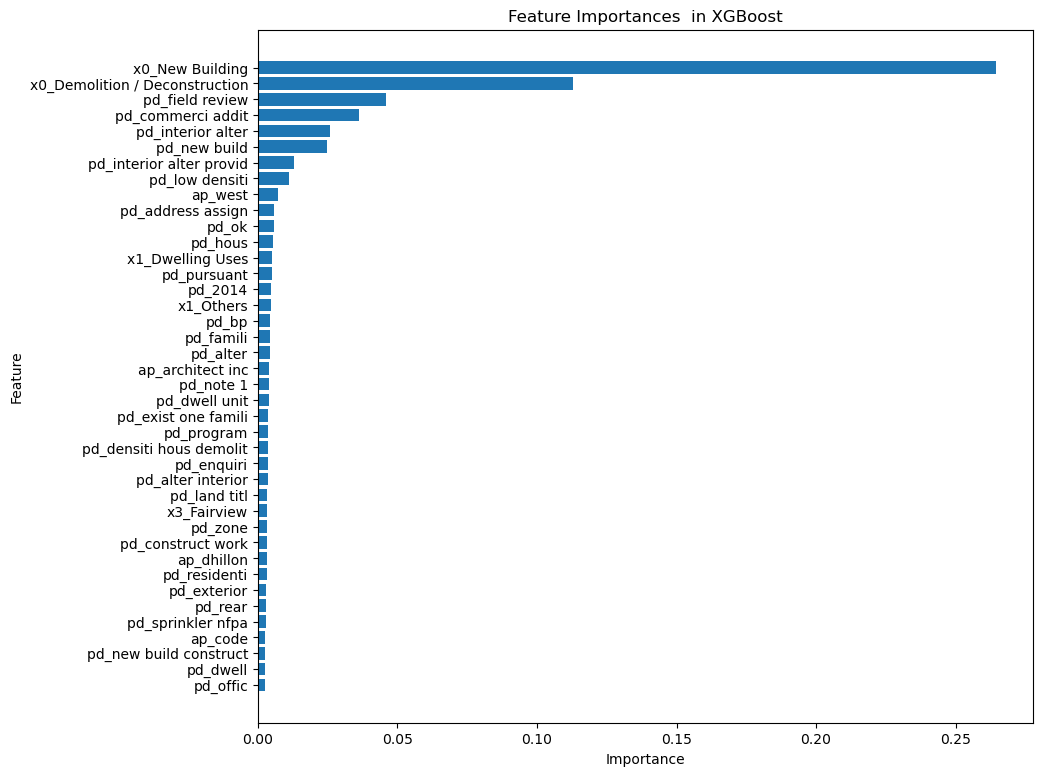

In [333]:
# Get feature importances
feature_importances = best_xgb_model.feature_importances_

# Get the names of the features
feature_names = X_train.columns

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select top 20 important features
feature_importance_df = feature_importance_df.head(40)
# Example: Sorting by importance and then by the length of feature name
feature_importance_df = feature_importance_df.sort_values(by=['Importance', 'Feature'], ascending=[True, False])



# Plot feature importances (optional)
plt.figure(figsize=(10, 9))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances  in XGBoost')
plt.show()